## some methods that I will use

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time


try:
    from imblearn.under_sampling import RandomUnderSampler 
except:
    !pip install imblearn

def plot_learning_curve_newdata(estimator, title, X, y, axes=None, ylim=None, cv=None,  n_jobs=None, scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5), d_name="Census pay", estimator2='', sp1='', sp2='', X2='', y2=''):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    tit = title +" " + d_name
    axes.set_title(tit)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Accuracy")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y,scoring=scoring,  cv=cv, n_jobs=n_jobs,   train_sizes=train_sizes,
        return_times=True,)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    train_sizes, train_scores2, test_scores2, fit_times2, _ = learning_curve(
        estimator2, X2, y2,scoring=scoring,  cv=cv, n_jobs=n_jobs,   train_sizes=train_sizes,
        return_times=True,)
    train_scores_mean2 = np.mean(train_scores2, axis=1)
    train_scores_std2 = np.std(train_scores2, axis=1)
    test_scores_mean2 = np.mean(test_scores2, axis=1)
    test_scores_std2 = np.std(test_scores2, axis=1)
    fit_times_mean2 = np.mean(fit_times2, axis=1)
    fit_times_std2 = np.std(fit_times2, axis=1)

        # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std, alpha=0.1,  color="r", )
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std, alpha=0.1, color="g", )
    
    xlab = 'Training score ' + sp1
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label=xlab)
    xlab2 = 'Cross validation score ' + sp1
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label=xlab2)
    
    
    axes.fill_between(train_sizes, train_scores_mean2 - train_scores_std2,
        train_scores_mean2 + train_scores_std2, alpha=0.1,  color="r", )
    axes.fill_between(train_sizes, test_scores_mean2 - test_scores_std2,
        test_scores_mean2 + test_scores_std2, alpha=0.1, color="g", )
    
    xlab = 'Training score ' + sp2
    axes.plot(train_sizes, train_scores_mean2, "o--", color="r", label=xlab)
    xlab2 = 'Cross validation score ' + sp2
    axes.plot(train_sizes, test_scores_mean2, "o--", color="g", label=xlab2)
  
    axes.legend(loc="best")
    plt.show()



In [2]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,  n_jobs=None, scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5), d_name="Census pay", title_extra= ''):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    tit = title +" " + d_name
    axes.set_title(tit)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

        # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    xlab = 'Training score' + title_extra
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label=xlab
    )
    xlab2 = 'Cross validation score' + title_extra
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label=xlab2
    )
    axes.legend(loc="best")
    plt.show()
    return axes


In [3]:
def val_curve(estimator, X, y, param_name, param_range, scoring, ds_name,  is_bar=False):
    train_scores, test_scores = validation_curve(estimator, X, y,  param_name=param_name,
                                                 param_range=param_range, scoring=scoring,)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    tit = "Validation Curve for " + ds_name
    plt.title(tit)
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
#     plt.ylim(0.0, 1.1)
    lw = 2

    if is_bar == False:
        plt.plot(param_range, train_scores_mean, label="Mean train scores", color="darkorange")
        plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,      alpha=0.2,
            color="darkorange",  lw=lw )


        plt.plot(param_range, test_scores_mean, label="Mean test scores", color="navy",)

        plt.fill_between( param_range,  test_scores_mean - test_scores_std,  test_scores_mean + test_scores_std,
            alpha=0.2, color="navy",    lw=lw,  )
        plt.legend(loc="best")
        plt.show()
    
    else:
        #------------  plotting ---------     
        ax = plt.gca()
        X = np.arange(0, len(param_range))

        ax.bar(X, train_scores_mean, color = 'b', width = 0.25, label = 'Training Accuracy')
        ax.bar(X+0.25, test_scores_mean, color = 'g', width = 0.25, label = "Validation Accuracy")
        plt.xticks(X, param_range)
    
        plt.legend(loc='lower left')
        plt.show()

    

In [4]:

def val_curve2(estimator, X, y, param_name, param_range, scoring, ds_name, depths):
    train_scores, test_scores = validation_curve(estimator, X, y,  param_name=param_name,
                                                 param_range=param_range, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    tit = "Validation Curve for " + ds_name
    plt.title(tit)
    xlab = param_name + ' depth'
    plt.xlabel(xlab)
    plt.ylabel("Accuracy")
#     plt.ylim(0.0, 1.1)
    lw = 2
    param_range = depths
    plt.plot(param_range, train_scores_mean, label="Mean train scores", color="darkorange")
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,      alpha=0.2,
        color="darkorange",  lw=lw )


    plt.plot(param_range, test_scores_mean, label="Mean test scores", color="navy",)
    
    plt.fill_between( param_range,  test_scores_mean - test_scores_std,  test_scores_mean + test_scores_std,
        alpha=0.2, color="navy",    lw=lw,  )
    plt.legend(loc="best")
    plt.show()
    

## Reading Datasets

Dataset 1:Adult-all csv: https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv

Dataset 2: https://www.kaggle.com/code/aman909/body-performance \
Outputs are 4 with all features numerical

In [5]:


rus = RandomUnderSampler(random_state=42)

# Read the data gill-attachmen

Names1 = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
          'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'Result']
data1 = pd.read_csv('adult-all.csv', header=None,  index_col=False, names = Names1)
data1.drop_duplicates(inplace=True)
y=data1['Result']
X= data1[data1.columns[data1.columns != 'Result']]
X_res, y_res = rus.fit_resample(X, y)
data1 = pd.concat([X_res, y_res], axis=1)
data1.head()

data2 = pd.read_csv('bodyPerformance.csv')
data2.drop_duplicates(inplace=True)
data2.head()



# sns.scatterplot(x="weight_kg", y="height_cm", hue= 'Clusters',  data=df, )



,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


### Cleaning datasets and replacing missing values
Assuming that missing values are represented with '?' which is the case with dataset 1


In [6]:
#------------ replaces the missing values with the most frequent value ---------------
def missing_vals(data1):
    for col in data1.columns:
        if '?' in set(data1[col]):
            print (col)
            print('? values in',col, ":", data1[col].value_counts()['?'])
            data1[col].replace('?', np.nan, inplace=True)
            print('Replacing ? with most frequent:', data1[col].mode().iloc[0])
            data1[col].fillna(data1[col].mode().iloc[0], inplace=True)
            print()
        elif data1[col].isna().any():
            print (col, ": nan values present")
            
            
#---------- takes data and convert columns to categories and stores the mappings in a dict ---- 
def convert_cats_labels(data, columns=None, cats_names_dict={}):
    d1c = pd.DataFrame()
    if columns == None:
        for col in data.columns:
            d1c[col] = data[col].astype('category')
            cats_names_dict[col] = dict(enumerate(d1c[col].cat.categories))
            d1c[col] = d1c[col].cat.codes
    
    else:
        for col in data.columns:
            if col in columns:
                d1c[col] = data[col].astype('category')
                cats_names_dict[col] = dict(enumerate(d1c[col].cat.categories))
                d1c[col] = d1c[col].cat.codes
            else:
                d1c[col] = data[col]
                
    return d1c, cats_names_dict
            
missing_vals(data1)
missing_vals(data2)



cols_to_cats_d1 = ['workclass', 'education', 'education-num', 'marital-status', 'occupation', 
          'relationship', 'race', 'sex', 'native-country', 'Result']

data1, codes_d1 = convert_cats_labels(data1, columns = cols_to_cats_d1)



cols_to_cats_d2 = ['gender', 'class']

data2, codes_d2 = convert_cats_labels(data2, columns = cols_to_cats_d2)

workclass
? values in workclass : 1053
Replacing ? with most frequent: Private

occupation
? values in occupation : 1056
Replacing ? with most frequent: Exec-managerial

native-country
? values in native-country : 398
Replacing ? with most frequent: United-States



### Splitting the data 70-30

In [7]:
from sklearn.model_selection import train_test_split
    
X_data1 = data1[data1.columns[data1.columns != 'Result']]
y_data1 = data1.loc[:, 'Result']

X_data2 = data2[data2.columns[data2.columns != 'class']]
y_data2 = data2.loc[:, 'class']


X_train1, X_test1, y_train1, y_test1 = train_test_split(X_data1, y_data1, test_size=0.3, random_state=38)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_data2, y_data2, test_size=0.3, random_state=38)
print("shape for data1 => training:", X_train1.shape, " and testing:", X_test1.shape)
print("shape for data2 => training:", X_train2.shape, " and testing:", X_test2.shape)

shape for data1 => training: (16353, 14)  and testing: (7009, 14)
shape for data2 => training: (9374, 11)  and testing: (4018, 11)


## Decision Trees

### Dataset 1

#### Unconstrained trees

In [8]:
traintimesd1 ={}
testtimesd1 ={}
traintimesd2={}
testtimesd2 = {}

final_accsd1 = {}
final_accsd2 = {}

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree  import export_graphviz
from sklearn import tree
import matplotlib.pyplot as plt
import sklearn
import time

try:
    from graphviz import Source
except:
    ! pip3 install graphviz 
    
from IPython.display import SVG

def scoring_wo_cons_dt(X_train1, y_train1, X_test1, y_test1, data_name='Census pay'):
    print("Without constraints for Dataset:" + data_name)
    clf = DecisionTreeClassifier(random_state=10)
    
    start = time.time()
    clf.fit(X_train1, y_train1)
    end = time.time()
    trainingtime = end - start
    print("Training time", round(trainingtime, 4), "seconds")
    
    training_score = clf.score(X_train1, y_train1)
    start = time.time()
    testing_score = clf.score(X_test1, y_test1)
    end = time.time()
    testingtime = end - start
    print("Scoring time", round(testingtime, 4), "seconds")
    
    print("Training Accuracy", training_score)
    print("Testing Accuracy", testing_score)
    return clf

          

#--------------------- showing the image ----------------
def show_tree(X_train1, clf, show=False, name="DTcensus_unconstrained"):
    if show:

        plt.figure(figsize=(40,20))  
        _ = tree.plot_tree(clf, feature_names = X_train1.columns, 
                     filled=True, fontsize=6, rounded = True)
        plt.show()
        plt.savefig(name+'.png')


sklearn.set_config(print_changed_only=False)

def print_tree_atts(clf):
    print("Max depth", clf.tree_.max_depth)
    print("Number of nodes", clf.tree_.node_count)
    print(clf)

          
clf1_uc = scoring_wo_cons_dt(X_train1, y_train1, X_test1, y_test1, "census")
print_tree_atts(clf1_uc)
print("-----------------------------------------------------------------")
clf2_uc = scoring_wo_cons_dt(X_train2, y_train2, X_test2, y_test2, "BodyPerf")
print_tree_atts(clf2_uc)


Without constraints for Dataset:census
Training time 0.0738 seconds
Scoring time 0.003 seconds
Training Accuracy 0.9998776982816608
Testing Accuracy 0.7567413325724069
Max depth 39
Number of nodes 5831
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=10, splitter='best')
-----------------------------------------------------------------
Without constraints for Dataset:BodyPerf
Training time 0.0702 seconds
Scoring time 0.0021 seconds
Training Accuracy 1.0
Testing Accuracy 0.6428571428571429
Max depth 26
Number of nodes 3941
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impuri

#### Validation curves

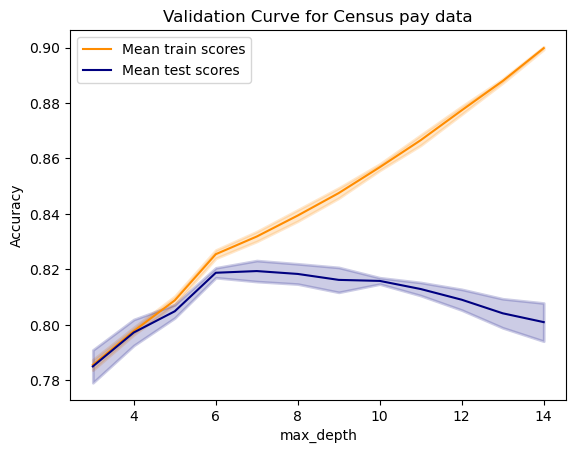

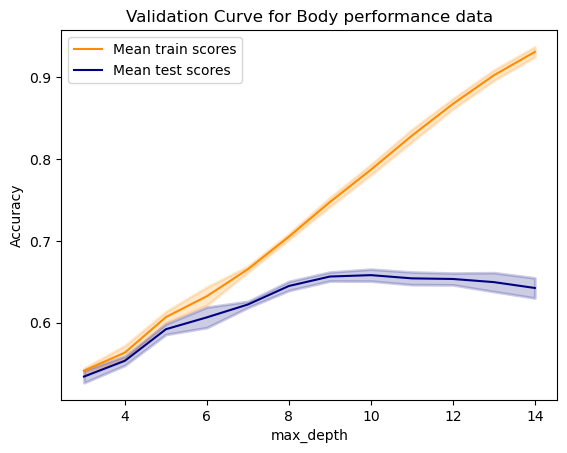

In [9]:
from sklearn.model_selection import validation_curve

max_depth_range = list(range(3,15))

tree = DecisionTreeClassifier(random_state = 50)
val_curve(tree, X_train1, y_train1, "max_depth", max_depth_range, "accuracy", "Census pay data")
val_curve(tree, X_train2, y_train2, "max_depth", max_depth_range, "accuracy", "Body performance data")

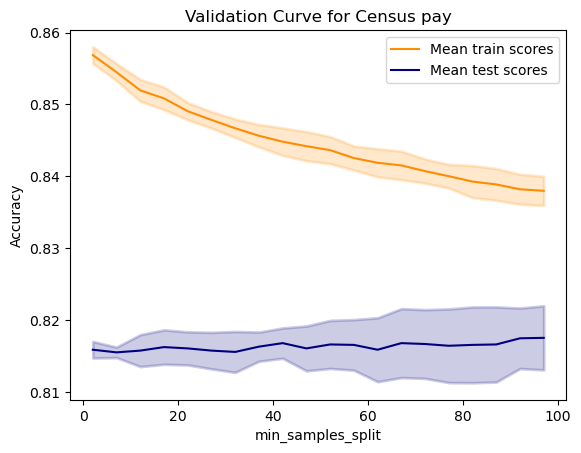

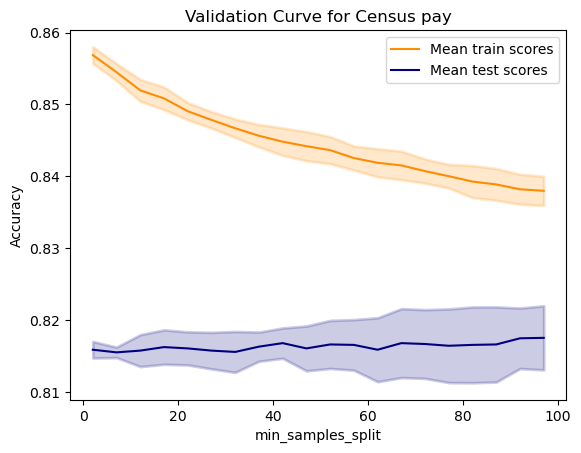

In [10]:
minsamplesplit_range = list(range(2,100,5))
tree = DecisionTreeClassifier(random_state = 50, max_depth=10)
val_curve(tree, X_train1, y_train1, "min_samples_split", minsamplesplit_range, "accuracy", "Census pay")
val_curve(tree, X_train1, y_train1, "min_samples_split", minsamplesplit_range, "accuracy", "Census pay")

### Pruning the trees

In [11]:
#--------------------------- early pruning ---------------- 
from sklearn.model_selection import RandomizedSearchCV

def prepruning_search (X_train1, y_train1, X_test1, y_test1, ds_name = 'census pay',
                       need_training = False, name_file='decision_tree'):
    if need_training == True:
        param_dist = {"max_depth": [6, 10],
                      "min_samples_split": [2,10, 50],
                      
                      "criterion": ["gini", "entropy"]}

        # Instantiate a Decision Tree classifier: tree
        tree = DecisionTreeClassifier(random_state = 50, min_samples_leaf= 20)

        # Instantiate the RandomizedSearchCV object: tree_cv
        tree_cv = RandomizedSearchCV(tree, param_dist,  n_iter=30, cv=5)
        tree_cv.fit(X_train1, y_train1)
        clf = tree_cv.best_estimator_
    
        start = time.time()
        clf.fit(X_train1, y_train1)
        end = time.time()
        trainingtime = end - start
        print("Training time", round(trainingtime, 4), "seconds")
    
        training_score = clf.score(X_train1, y_train1)
        
        start = time.time()
        testing_score = clf.score(X_test1, y_test1)
        end = time.time()
        testingtime = end - start
        print("Scoring time", round(testingtime, 4), "seconds")
    
    
        print("Dataset:", ds_name)
        print("Training Accuracy", training_score)
        print("Testing Accuracy", testing_score)


        # open a file, where you ant to store the decision classifier found after gridsearch
        file = open(name_file, 'wb')

        # dump information to that file
        pickle.dump(clf, file)

        # close the file
        file.close()


    else:
        #------------ taking the pickled decision tree out
        # -------------- skip last cell -------------

        file = open(name_file, 'rb')
        clf = pickle.load(file)
        file.close()
    
    return clf

clf1 = prepruning_search(X_train1, y_train1, X_test1, y_test1, ds_name = 'census pay',
                       need_training = True, name_file='dt_censuspay')
print_tree_atts(clf1)


print("-----------------------------------------------------------------")
clf2 = prepruning_search(X_train2, y_train2, X_test2, y_test2, ds_name = 'body perf',
                       need_training = True, name_file='dt_bodyperf')
print_tree_atts(clf2)

show_tree(X_train1, clf1, show=False, name="DTcensus_prepruned.png")
show_tree(X_train2, clf2, show=False, name="bodyperf_prepruned")

/home/ai/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training time 0.0271 seconds
Scoring time 0.0021 seconds
Dataset: census pay
Training Accuracy 0.8230294135632605
Testing Accuracy 0.8088172349835925
Max depth 6
Number of nodes 91
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=20,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=50, splitter='best')
-----------------------------------------------------------------


/home/ai/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training time 0.0623 seconds
Scoring time 0.0018 seconds
Dataset: body perf
Training Accuracy 0.7277576274802645
Testing Accuracy 0.6769537083125934
Max depth 10
Number of nodes 421
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=20,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=50, splitter='best')


### Cost complexity pruning
For this type of pruning, I will be making a separate validation set to set the value of alpha. 
Impurities increase as alphas increase because more of the trees are pruned and therefore in each leaf node, more of a mix of all outputs are present.

In [12]:
#---- code taken from https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html ----
def need_val_test(X_test1, y_test1):
    X_test11, X_val1, y_test11, y_val1 = train_test_split(X_test1, y_test1, test_size=0.4, random_state=38)
    return X_test11, X_val1, y_test11, y_val1

def impurities_alphas(clf, X_train1, y_train1, show=True):
    res = clf.cost_complexity_pruning_path(X_train1, y_train1)
    if show:
        plt.plot(res['ccp_alphas'], res['impurities'], marker="o", drawstyle="steps-post", color='b')
        plt.gca().set_xlabel('alphas')
        plt.gca().set_ylabel('Impurities')
        plt.title("How impurities grow bigger as alpha increases")
        plt.show()
    return res


def alphas_nodes_depth(res, X_train1, y_train1, show=True):
    clfs = []
    node_counts = []
    depths = []
    for ccp_alpha in res['ccp_alphas']:
        clf = DecisionTreeClassifier(random_state=10, ccp_alpha=ccp_alpha)
        clf.fit(X_train1, y_train1)
        clfs.append(clf)
        node_counts.append(clfs[-1].tree_.node_count)
        depths.append(clfs[-1].tree_.max_depth)


    # node_counts = [clf.tree_.node_count for clf in clfs]
    # depth = [clf.tree_.max_depth for clf in clfs]
    if show:
        fig, ax = plt.subplots(2, 1)
        ax[0].plot(res['ccp_alphas'], node_counts, marker="o", drawstyle="steps-post")
        ax[0].set_xlabel("alpha")
        ax[0].set_ylabel("number of nodes")
        ax[0].set_title("Number of nodes vs alpha")
        ax[0].set_ylim([0, 100])
        ax[1].plot(res['ccp_alphas'], depths, marker="o", drawstyle="steps-post")
        ax[1].set_xlabel("alpha")
        ax[1].set_ylabel("depth of tree")
        ax[1].set_title("Depth vs alpha")
        fig.tight_layout()
        plt.show()
    return clfs
    
def alpha_acc(clfs, X_train1, y_train1, X_val1, y_val1, res, limit):
    train_scores = [clf.score(X_train1, y_train1) for clf in clfs]
    test_scores = [clf.score(X_val1, y_val1) for clf in clfs]

    fig, ax = plt.subplots()
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs alpha for training and testing sets")
    ax.plot(res['ccp_alphas'], train_scores, marker="o", label="train", drawstyle="steps-post")
    ax.plot(res['ccp_alphas'], test_scores, marker="o", label="test", drawstyle="steps-post")
    if limit:
        ax.set_xlim([0, limit])
    ax.legend()
    plt.show()

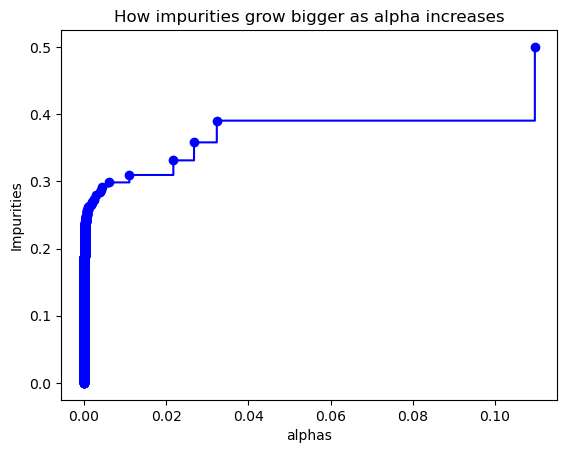

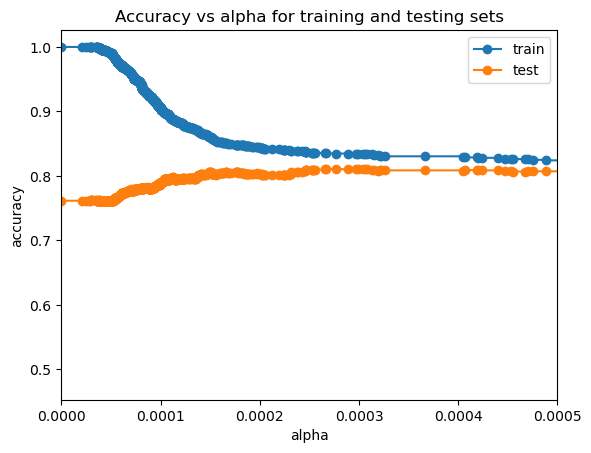

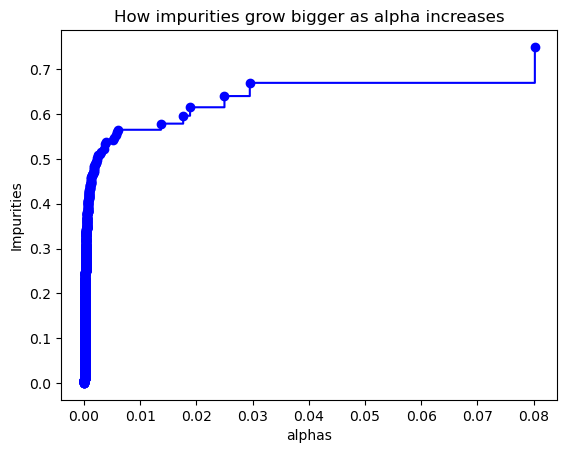

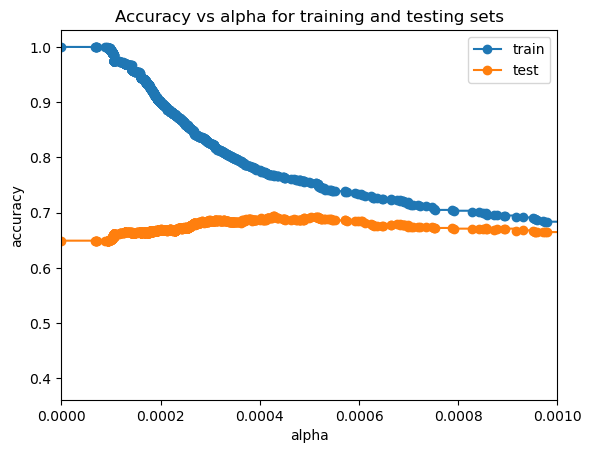

In [13]:
def run_all_cp(clf, X_train1, y_train1, X_test1, y_test1, limit):
    X_test11, X_val1, y_test11, y_val1 = need_val_test(X_test1, y_test1)

    res = impurities_alphas(clf, X_train1, y_train1, True)
    plt.close("all") #this is the line to be added

    clfs = alphas_nodes_depth(res, X_train1, y_train1, False)
    plt.close("all") #this is the line to be added

    alpha_acc(clfs, X_train1, y_train1, X_val1, y_val1, res, limit)
    plt.close("all") #this is the line to be added

clf = DecisionTreeClassifier(random_state = 50)
run_all_cp(clf, X_train1, y_train1, X_test1, y_test1, 0.0005)

clf = DecisionTreeClassifier(random_state = 50)
run_all_cp(clf, X_train2, y_train2, X_test2, y_test2, 0.001)

In [14]:
def postpruning(X_train1, y_train1, X_test1, y_test1, perfect_a, d_name="census pay", traintimes={}, 
                testtimes={}, accs={}):
    clf = DecisionTreeClassifier(random_state=10, ccp_alpha = perfect_a)
    
    start = time.time()
    clf.fit(X_train1, y_train1)
    end = time.time()
    trainingtime = end - start
    print("Training time", round(trainingtime, 4), "seconds")
    traintimes['dt'] = trainingtime

    training_score = clf.score(X_train1, y_train1)
    
    start = time.time()
    testing_score = clf.score(X_test1, y_test1)
    end = time.time()
    testingtime = end - start
    testtimes['dt'] = testingtime
    print("Scoring time", round(testingtime, 4), "seconds")
    
    print("Dataset", d_name)
    print("Training Accuracy", training_score)
    print("Testing Accuracy", testing_score)
    show_tree(X_train1, clf, show=False, name="DTcensus_postpruned.png")
    print_tree_atts(clf)
    accs['dt'] = testing_score
    return clf

ppclf1 = postpruning(X_train1, y_train1, X_test1, y_test1, 0.00025,"Census pay", traintimesd1, testtimesd1, final_accsd1)
print("----------------------------------------------------")
ppclf2 = postpruning(X_train2, y_train2, X_test2, y_test2, 0.0004, "Body_performance", traintimesd2, testtimesd2, final_accsd2)

Training time 0.0994 seconds
Scoring time 0.0025 seconds
Dataset Census pay
Training Accuracy 0.8362991500030575
Testing Accuracy 0.8159509202453987
Max depth 13
Number of nodes 165
DecisionTreeClassifier(ccp_alpha=0.00025, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=10, splitter='best')
----------------------------------------------------
Training time 0.0824 seconds
Scoring time 0.0018 seconds
Dataset Body_performance
Training Accuracy 0.777789630893962
Testing Accuracy 0.6896465903434544
Max depth 13
Number of nodes 497
DecisionTreeClassifier(ccp_alpha=0.0004, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_

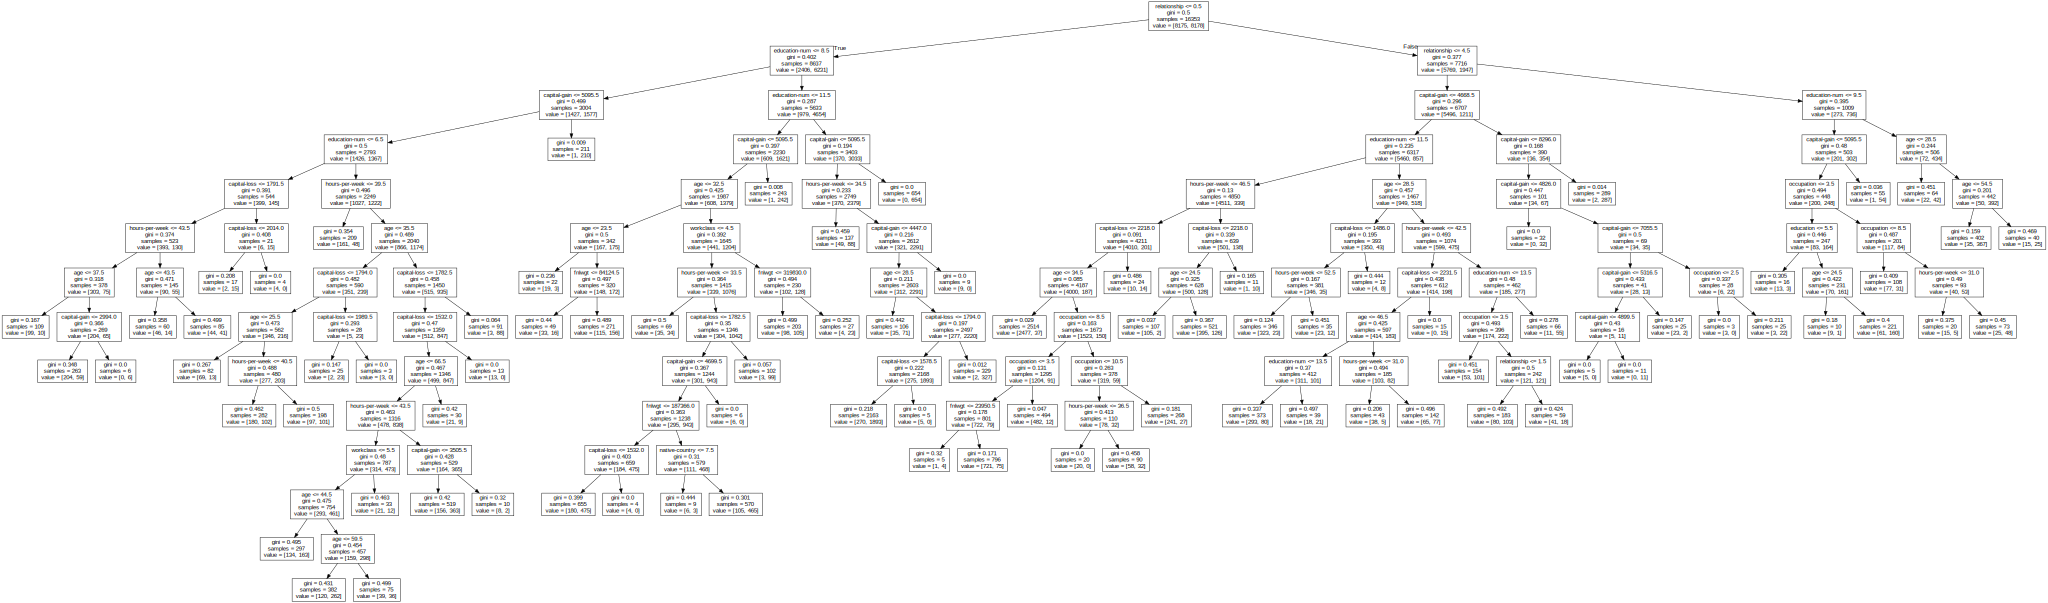

In [15]:
# show_tree(X_train1, ppclf1, show=True, name="DTcensus_postpruned.png")
from sklearn import tree
graph = Source( tree.export_graphviz(ppclf1, out_file=None, feature_names=X_train1.columns))
SVG(graph.pipe(format='svg'))

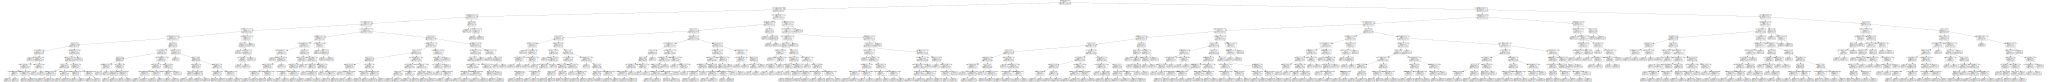

In [16]:
# show_tree(X_train1, ppclf1, show=True, name="DTcensus_postpruned.png")

clf1_ucp = DecisionTreeClassifier(random_state=10, max_depth=11)
clf1_ucp.fit(X_train1, y_train1)


from sklearn import tree
graph = Source( tree.export_graphviz(clf1_ucp, out_file=None, feature_names=X_train1.columns))
SVG(graph.pipe(format='svg'))

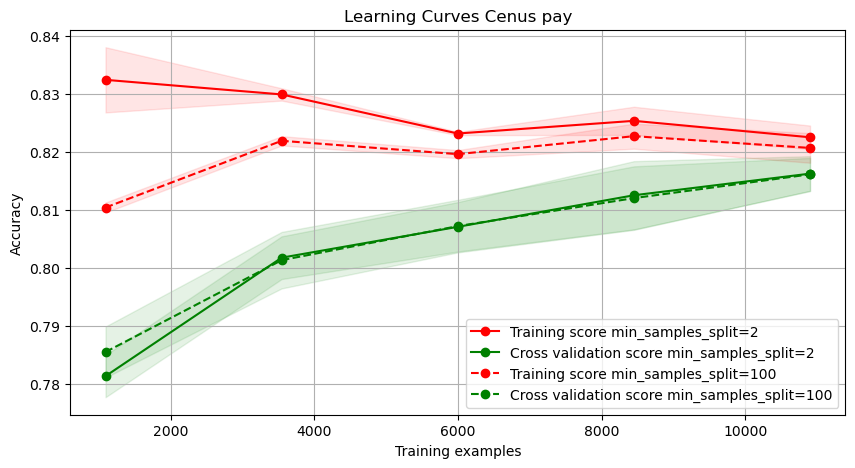

In [17]:
##learning curves
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
title="Learning Curves"

clf_mss_2 = DecisionTreeClassifier(max_depth=6, random_state = 50, min_samples_split= 2)
clf_mss_100  = DecisionTreeClassifier(max_depth=6,random_state = 50, min_samples_split= 100)
plot_learning_curve_newdata(clf_mss_2, title, X_train1, y_train1, axes=axes, ylim=None, cv=3,  n_jobs=-1, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5), d_name="Cenus pay", estimator2=clf_mss_100, sp1='min_samples_split=2', 
                     sp2='min_samples_split=100', X2=X_train1, y2=y_train1)

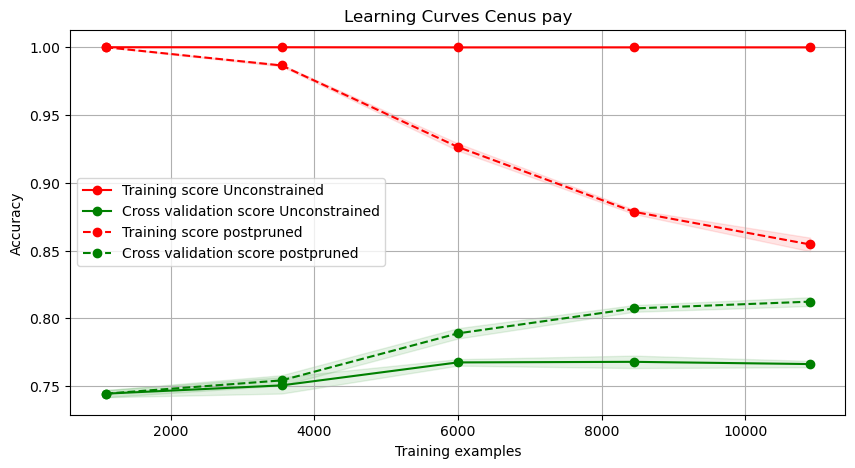

In [18]:
##learning curves
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
title="Learning Curves"

plot_learning_curve_newdata(clf1_uc, title, X_train1, y_train1, axes=axes, ylim=None, cv=3,  n_jobs=-1, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5), d_name="Cenus pay", estimator2=ppclf1, sp1='Unconstrained', 
                     sp2='postpruned', X2=X_train1, y2=y_train1)


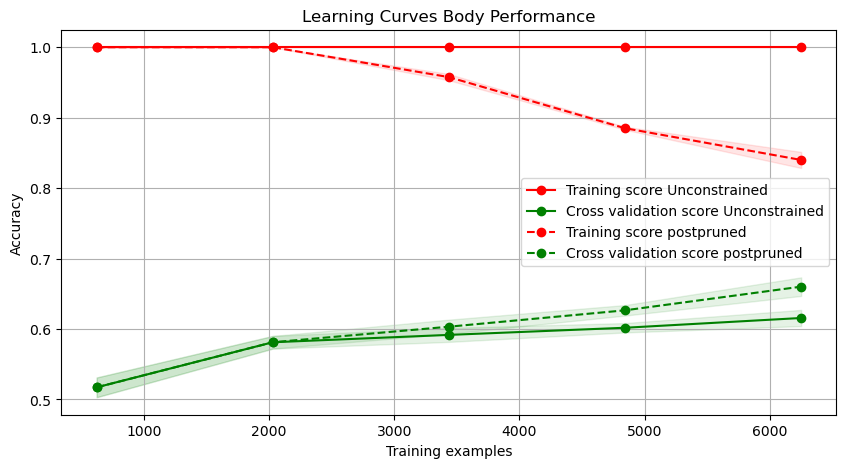

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
title="Learning Curves"
plot_learning_curve_newdata(clf2_uc, title, X_train2, y_train2, axes=axes, ylim=None, cv=3,  n_jobs=-1, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5), d_name="Body Performance", estimator2=ppclf2, sp1='Unconstrained', 
                     sp2='postpruned', X2=X_train2, y2=y_train2)

## KNN classifier

### Unconstrained

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train1, y_train1)
x_scaled1 = scaler.transform(X_train1)
x_scaled1 = pd.DataFrame(x_scaled1, columns=X_train1.columns)
xtest_scaled1 = scaler.transform(X_test1)
xtest_scaled1 = pd.DataFrame(xtest_scaled1, columns=X_train1.columns)

scaler = StandardScaler()
scaler.fit(X_train2, y_train2)
x_scaled2 = scaler.transform(X_train2)
x_scaled2 = pd.DataFrame(x_scaled2, columns=X_train2.columns)
xtest_scaled2 = scaler.transform(X_test2)
xtest_scaled2 = pd.DataFrame(xtest_scaled2, columns=X_train2.columns)

def scoring_wo_cons_knn(X_train1, y_train1, X_test1, y_test1):
    neigh = KNeighborsClassifier()
    start = time.time()
    neigh.fit(X_train1, y_train1)
    end = time.time()
    trainingtime = end - start
    print("Training time", round(trainingtime, 4), "seconds")
    
    train_sc = neigh.score(X_train1, y_train1)
    
    start = time.time()
    test_sc = neigh.score(X_test1, y_test1)
    end = time.time()
    testingtime = end - start
    print("Testing time", round(testingtime, 4), "seconds")
    
    print("Training score w/o GS", train_sc)
    print("Testing score w/o GS", test_sc)
    return neigh

# ---------------------------------------------------------------- #

print("Dataset1: Census pay")
clf1=scoring_wo_cons_knn(x_scaled1, y_train1, xtest_scaled1, y_test1)
print(clf1)
print("------------------------------------------")
print("Dataset2: Body performance")
clf2=scoring_wo_cons_knn(x_scaled2, y_train2, xtest_scaled2, y_test2)


Dataset1: Census pay
Training time 0.0344 seconds
Testing time 1.7236 seconds
Training score w/o GS 0.8471840029352412
Testing score w/o GS 0.7838493365672706
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
------------------------------------------
Dataset2: Body performance
Training time 0.0138 seconds
Testing time 0.3784 seconds
Training score w/o GS 0.7163430765948368
Testing score w/o GS 0.5960676953708313


#### Dataset 1

#### validation curves

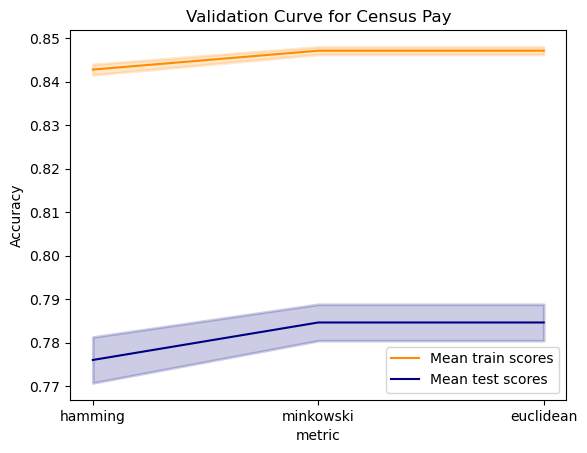

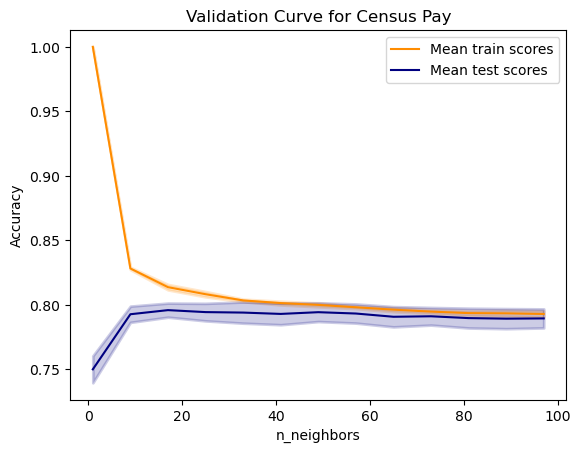

----------------------------------------------------------
Prepruned knn for Dataset1: Census pay
Training time 0.0403  Testing time 2.1767 seconds
Training score 0.8181373448296949  Testing score 0.789841632187188
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')


In [21]:
# -------------------------------------- dataset 1 ----------------------
k_range = list(range(1,100,8))
metric = ['hamming', 'minkowski', 'euclidean']
# wei_range = ['uniform', 'distance']
leaf_s_range = list(range(1,50,5))


knn = KNeighborsClassifier()
val_curve(knn, x_scaled1, y_train1, param_name='metric', param_range=metric, scoring = "accuracy", 
          ds_name='Census Pay')

knn = KNeighborsClassifier(metric='minkowski')
val_curve(knn, x_scaled1, y_train1, param_name='n_neighbors', param_range=k_range, scoring = "accuracy", 
          ds_name='Census Pay')


# val_curve(knn, x_scaled1, y_train1, param_name='weights', param_range=wei_range, scoring = "accuracy", 
#           ds_name='Body Performance')


knn1 = KNeighborsClassifier(metric = "minkowski", weights='uniform', n_neighbors=15)
start = time.time()
knn1.fit(x_scaled1, y_train1)
end = time.time()
trtime = end - start 

trs = knn1.score(x_scaled1, y_train1)
s = time.time()
ts = knn1.score(xtest_scaled1, y_test1)
e = time.time()
tt = e - s

print("----------------------------------------------------------")
print("Prepruned knn for Dataset1: Census pay")
print("Training time", round(trtime, 4), " Testing time", round(tt, 4), "seconds")
print("Training score", trs, " Testing score", ts)
print(knn1)

### Testing theory that reducing features improves accuracy (Data 1)
For dataset 1, selecting a few columns and testing with different values to check how different is the accuracy. 

In [22]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

def knn_reduce_feats(X_train1, y_train1, X_test1, y_test1, method = "columns", columns = [], nfeats=8 ) :
    if method == f_classif or method == chi2:
        selector = SelectKBest(method, k=nfeats)
        model = selector.fit(X_train1, y_train1)
        cols = model.get_support(indices=True)
        features_df_new = X_train1.iloc[:,cols]
        print(features_df_new.columns)

        X_new = model.transform(X_train1)
        test_new = selector.transform(X_test1)
    else:
        X_new = X_train1[columns]
        X_new.loc[:,'age'] = 0.7*X_new.loc[:,'age']
        test_new = X_test1[columns]
        test_new.loc[:,'age'] = 0.7* test_new.loc[:,'age']
        
        n = "relationship"
        X_new.loc[:,n] =2*X_new.loc[:,n]
        test_new.loc[:,n] = 2* test_new.loc[:,n]


    neigh = KNeighborsClassifier()
    params_to_tune = {'n_neighbors':[10, 15, 18, 25], 'weights': [ 'uniform'],
                      'metric':['minkowski']
                     }

    rc = RandomizedSearchCV(neigh, params_to_tune,  n_iter=30, cv=5)
    neigh = rc.fit(X_new, y_train1)

    knn_best = neigh.best_estimator_
    s=time.time()
    knn_best.fit(X_new, y_train1)
    e=time.time()
    traintimesd1['knn']=(e-s)
    tr_sc = knn_best.score(X_new, y_train1)
    
    s=time.time()
    test_sc = knn_best.score(test_new, y_test1)
    e=time.time()
    
    testtimesd1['knn']=(e-s)
    final_accsd1['knn'] = test_sc
    print("Training score:", tr_sc, " Testing score:", test_sc)
    
    return knn_best, X_new

print("My own 8 columns")
columns = ['age', 'sex', 'occupation', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
knn_best, X_new = knn_reduce_feats(X_train1, y_train1, X_test1, y_test1, "columns", columns)

My own 8 columns


/home/ai/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/ai/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=30. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training score: 0.8445545159909497  Testing score: 0.8140961620773292


### Dataset 2

#### Validation curves

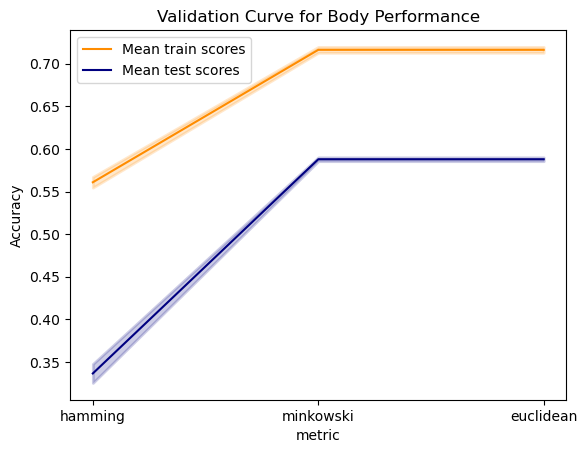

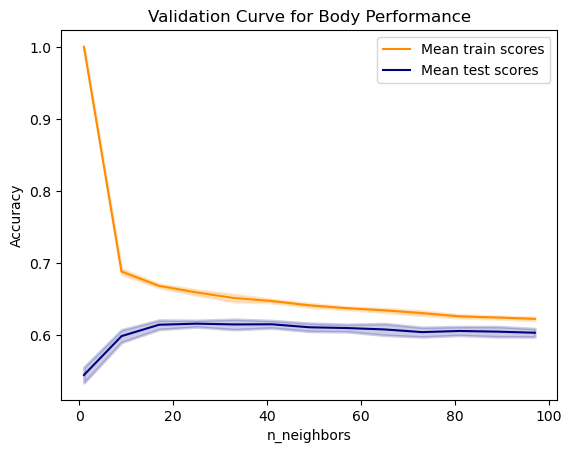

----------------------------------------------------------
Prepruned knn for Dataset2: Body Performance
Training time 0.0142  Testing time 0.473 seconds
Training score 1.0  Testing score 0.6331508213041314


In [23]:
# -------------- dataset 2---------------------------
k_range = list(range(1,100,8))
metric = ['hamming', 'minkowski', 'euclidean']
# wei_range = ['uniform', 'distance']
leaf_s_range = list(range(1,50,5))


knn = KNeighborsClassifier()
val_curve(knn, x_scaled2, y_train2, param_name='metric', param_range=metric, scoring = "accuracy", 
          ds_name='Body Performance')

knn = KNeighborsClassifier(metric='minkowski')
val_curve(knn, x_scaled2, y_train2, param_name='n_neighbors', param_range=k_range, scoring = "accuracy", 
          ds_name='Body Performance')


# val_curve(knn, x_scaled1, y_train1, param_name='weights', param_range=wei_range, scoring = "accuracy", 
#           ds_name='Body Performance')


knn2 = KNeighborsClassifier(metric = "minkowski", weights='distance', n_neighbors=25)
start = time.time()
knn2.fit(x_scaled2, y_train2)
end = time.time()
trtime = end - start 

trs = knn2.score(x_scaled2, y_train2)
s = time.time()
ts = knn2.score(xtest_scaled2, y_test2)
e = time.time()
tt = e - s

print("----------------------------------------------------------")
print("Prepruned knn for Dataset2: Body Performance")
print("Training time", round(trtime, 4), " Testing time", round(tt, 4), "seconds")
print("Training score", trs, " Testing score", ts)


### Changing weights of the columns to achieve better results (Data 2)

In [24]:
columns = ['age', 'gender', 'weight_kg', 'body fat_%', 'gripForce','sit and bend forward_cm', 'sit-ups counts', 'broad jump_cm' ]
knn = KNeighborsClassifier(metric = "minkowski", weights='distance', n_neighbors=25)

xscaled_sel = x_scaled2.loc[:, columns]
xtest_scaled2_sel = xtest_scaled2.loc[:, columns]

# 0.6294176207068193 if we give more importance to important feats
c=2.8
xscaled_sel['sit and bend forward_cm']= c*xscaled_sel['sit and bend forward_cm']
xscaled_sel['sit-ups counts']=c*0.99*xscaled_sel['sit-ups counts']
xscaled_sel['broad jump_cm']= 0.4*xscaled_sel['broad jump_cm']
xscaled_sel['body fat_%']= 0.3*xscaled_sel['body fat_%']
xscaled_sel['age']=2.3*xscaled_sel['age']



xtest_scaled2_sel['sit and bend forward_cm']= c*xtest_scaled2_sel['sit and bend forward_cm']
xtest_scaled2_sel['sit-ups counts']= c*0.99*xtest_scaled2_sel['sit-ups counts']
xtest_scaled2_sel['broad jump_cm']= 0.4*xtest_scaled2_sel['broad jump_cm']
xtest_scaled2_sel['body fat_%']= 0.3*xtest_scaled2_sel['body fat_%']
xtest_scaled2_sel['age']= 2.3*xtest_scaled2_sel['age']

knn_sc = KNeighborsClassifier(metric='minkowski', n_neighbors=15, weights='uniform')
start = time.time()
knn_sc.fit(xscaled_sel, y_train2)
end = time.time()
trtime = end - start 
traintimesd2['knn'] = trtime

trs = knn_sc.score(xscaled_sel, y_train2)
s = time.time()
ts = knn_sc.score(xtest_scaled2_sel, y_test2)
e = time.time()
tt = e - s
testtimesd2['knn'] = tt

final_accsd2['knn'] = ts

print("----------------------------------------------------------")
print("Prepruned knn for Dataset2: Body Performance")
print("Training time", round(trtime, 4), " Testing time", round(tt, 4), "seconds")
print("Training score", trs, " Testing score", ts)


----------------------------------------------------------
Prepruned knn for Dataset2: Body Performance
Training time 0.0147  Testing time 0.1829 seconds
Training score 0.7360785150416045  Testing score 0.7137879542060727


### Learning curves

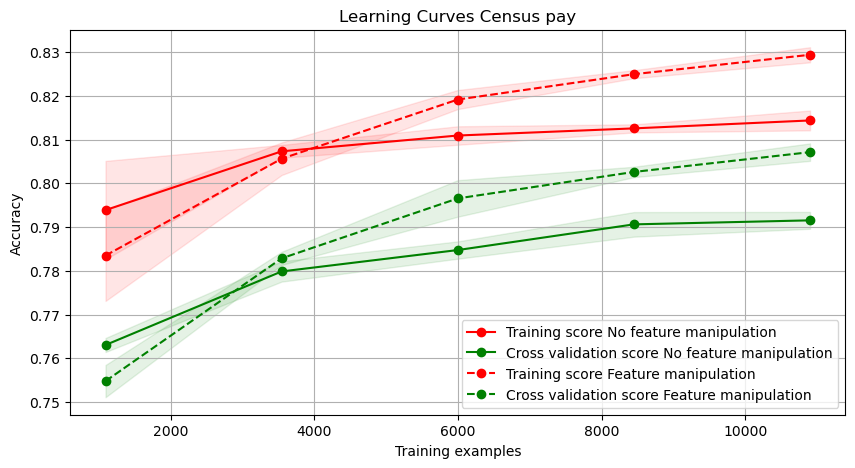

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
title="Learning Curves"
plot_learning_curve_newdata(estimator=knn1, title=title, X=x_scaled1, y=y_train1, axes=axes, ylim=None, cv=3,
                     n_jobs=-1, scoring="accuracy",train_sizes=np.linspace(0.1, 1.0, 5), d_name='Census pay',
                     estimator2=knn_sc, sp1='No feature manipulation', sp2='Feature manipulation', X2=X_new,
                     y2=y_train1 )


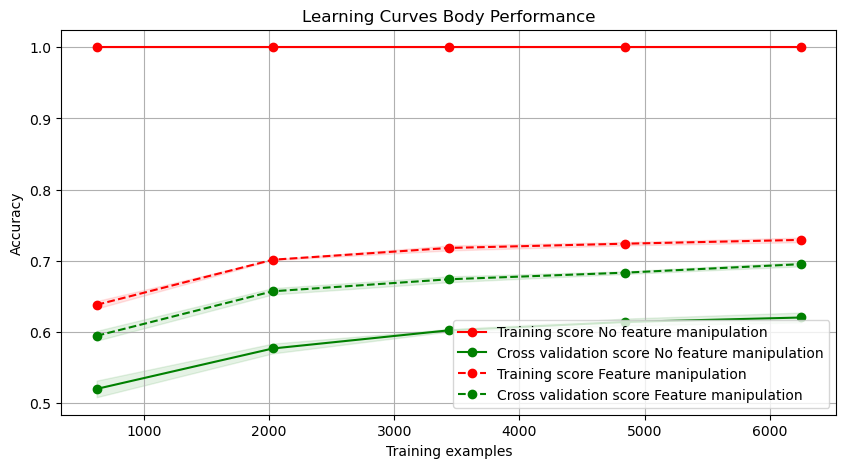

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
title="Learning Curves"

knn2 = KNeighborsClassifier(metric = "minkowski", weights='distance', n_neighbors=25)
knn_sc = KNeighborsClassifier(metric='minkowski', n_neighbors=15, weights='uniform')

plot_learning_curve_newdata(estimator=knn2, title=title, X=x_scaled2, y=y_train2, axes=axes, ylim=None, cv=3,
                     n_jobs=-1, scoring="accuracy",train_sizes=np.linspace(0.1, 1.0, 5), d_name='Body Performance',
                     estimator2=knn_sc, sp1='No feature manipulation', sp2='Feature manipulation', X2=xscaled_sel,
                     y2=y_train2 )

## Neural Networks

In [27]:
from sklearn.neural_network import MLPClassifier
#--- relu does better than tanh and logistic or use smaller learning rate for logistica nd tanh

#----- scale the data --------

scaler = StandardScaler()
scaler.fit(X_train1, y_train1)
x_train1 = scaler.transform(X_train1)
x_train1 = pd.DataFrame(x_train1, columns=X_train1.columns)
x_test1 = scaler.transform(X_test1)
x_test1 = pd.DataFrame(x_test1, columns=X_train1.columns)

scaler = StandardScaler()
scaler.fit(X_train2, y_train2)
x_train2 = scaler.transform(X_train2)
x_train2 = pd.DataFrame(x_train2, columns=X_train2.columns)
x_test2 = scaler.transform(X_test2)
x_test2 = pd.DataFrame(x_test2, columns=X_train2.columns)

#---- code taken from https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html ----
def need_val_test(X_test1, y_test1):
    X_test11, X_val1, y_test11, y_val1 = train_test_split(X_test1, y_test1, test_size=0.4, random_state=38)
    return X_test11, X_val1, y_test11, y_val1
x_test11, x_val1, y_test11, y_val1 = need_val_test(x_test1, y_test1)
x_test22, x_val2, y_test22, y_val2 = need_val_test(x_test2, y_test2)


In [28]:
columns = ['weight_kg', 'body fat_%', 'gripForce','sit and bend forward_cm', 'sit-ups counts', 'broad jump_cm' ]

In [29]:


params = [
    {'solver':'adam', 'learning_rate_init':0.001, 'learning_rate' : 'adaptive', 'activation':'relu'},
    {'solver':'adam', 'learning_rate_init':0.0001, 'learning_rate': 'adaptive', 'activation' : 'logistic'},
    {'solver':'adam', 'learning_rate_init':0.0001, 'learning_rate': 'adaptive', 'activation' : 'tanh'}
]

params = [
    {'hidden_layer_sizes': (50, 50, 50, 50)},
    {'hidden_layer_sizes': (25, 20, 20, 25)},
    {'hidden_layer_sizes': (10, 10, 10, 10)},
    
    {'hidden_layer_sizes': (50, 50, 50)},
    {'hidden_layer_sizes': (25, 20, 20)},
    {'hidden_layer_sizes': (10, 10, 10)},
    {'hidden_layer_sizes': (5, 5, 5)},
    {'hidden_layer_sizes': (20, 10, 20)},
    
    {'hidden_layer_sizes': (100, 100)},
    {'hidden_layer_sizes': (50, 50)},
    {'hidden_layer_sizes': (25, 25)},
    {'hidden_layer_sizes': (8, 8)},
    {'hidden_layer_sizes': (10, 10)},
    {'hidden_layer_sizes': (15, 15)},
    
    {'hidden_layer_sizes': (100)},
    {'hidden_layer_sizes': (50)},
    {'hidden_layer_sizes': (25)},
]


layers= []
values_training = []
values_testing = []
for param in params:

    clf = MLPClassifier(**param , random_state=10, max_iter=500, solver='adam', learning_rate_init=0.1, 
    learning_rate='adaptive',activation='relu')
    clf.fit(x_train2, y_train2)
    trs = clf.score(x_train2, y_train2)
    ts = clf.score(x_val2, y_val2)
    print("Training score:", trs, " validation score:", ts, param['hidden_layer_sizes'])
    layers.append(str(param['hidden_layer_sizes']))
    values_training.append(trs)
    values_testing.append(ts)



Training score: 0.6895668871346277  validation score: 0.7014925373134329 (50, 50, 50, 50)
Training score: 0.6889268188606785  validation score: 0.6890547263681592 (25, 20, 20, 25)
Training score: 0.7085555792617879  validation score: 0.7101990049751243 (10, 10, 10, 10)
Training score: 0.722210369106038  validation score: 0.7157960199004975 (50, 50, 50)
Training score: 0.7354384467676552  validation score: 0.7332089552238806 (25, 20, 20)
Training score: 0.7139961595903563  validation score: 0.7269900497512438 (10, 10, 10)
Training score: 0.6523362491999146  validation score: 0.6648009950248757 (5, 5, 5)
Training score: 0.7147429059099637  validation score: 0.7139303482587065 (20, 10, 20)
Training score: 0.7452528269682099  validation score: 0.7238805970149254 (100, 100)
Training score: 0.7379987198634521  validation score: 0.7369402985074627 (50, 50)
Training score: 0.7370386174525283  validation score: 0.7356965174129353 (25, 25)
Training score: 0.7053552378920418  validation score: 0.

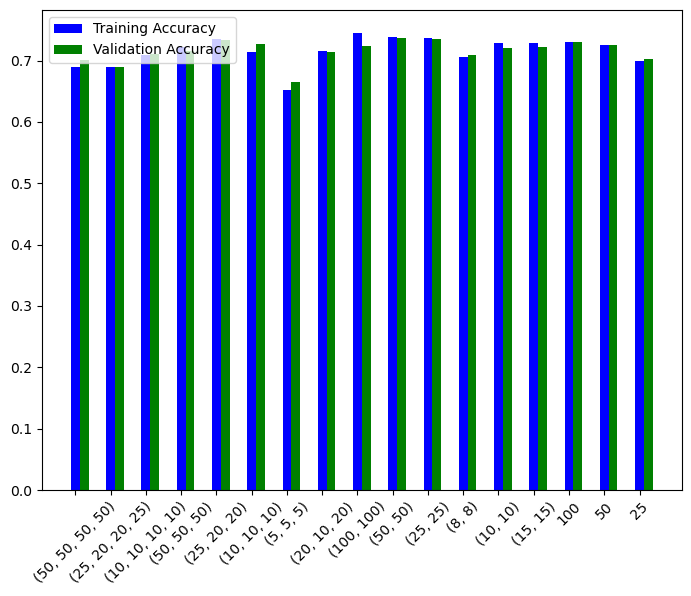

In [30]:
#------------  plotting ---------     
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.arange(0, len(layers))

ax.bar(layers, values_training, color = 'b', width = 0.25, label = 'Training Accuracy')
ax.bar(X+0.25, values_testing, color = 'g', width = 0.25, label = "Validation Accuracy")

plt.legend()
plt.xticks(rotation = 45)
plt.show()


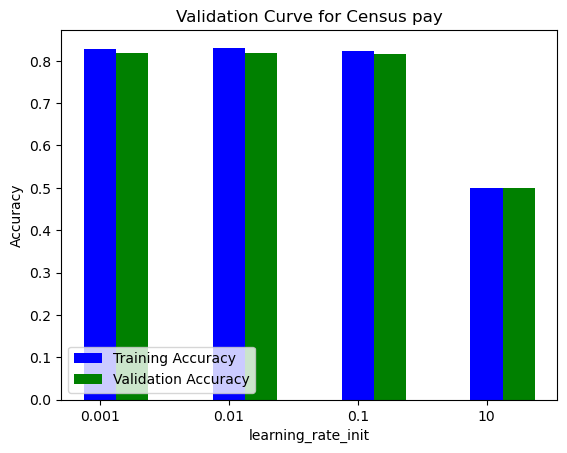

In [31]:
l_range = [0.001, 0.01, 0.1, 10]
clf_1 = MLPClassifier(random_state=10, max_iter=300, solver='adam', learning_rate_init=0.001,activation='relu', 
                      hidden_layer_sizes =(10, 15))


val_curve(clf_1, x_train1, y_train1, "learning_rate_init", l_range, "accuracy", "Census pay", True)


score with clf2 0.8282272365926742 0.8178359096313912
Training score: 0.8287164434660307  validation score: 0.8195005945303211
Training time 9.5383  Testing time 0.0027 seconds


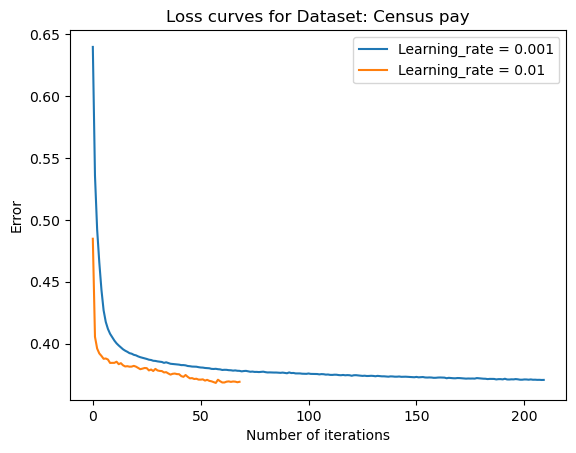

Training score: 0.7525069340729678  validation score: 0.7385892116182573
Training time 9.2695  Testing time 0.0026 seconds


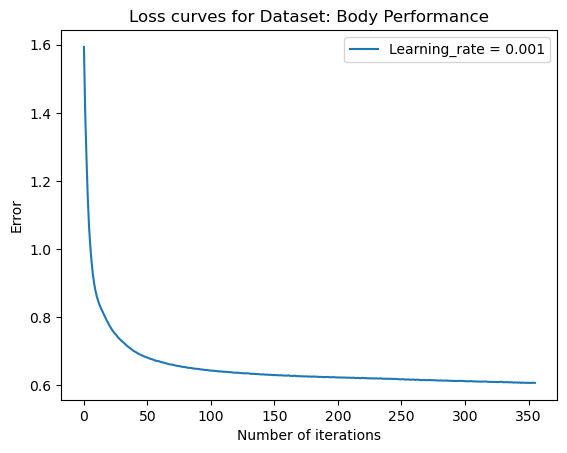

In [64]:


clf_1 = MLPClassifier(random_state=10, max_iter=500, solver='adam', learning_rate_init=0.001,activation='relu', 
                      hidden_layer_sizes =(10, 15))

clf_2 = MLPClassifier(random_state=10, max_iter=500, solver='adam', learning_rate_init=0.001,activation='relu', hidden_layer_sizes =(10, 10))

def start_training (clf, x_train1, y_train1, x_test11, y_test11, dname='Census pay', trti={}, tsti={}, acc={}, extra_clf = False ):
    
    start = time.time()
    clf.fit(x_train1, y_train1)
    end = time.time()
    trtime = end - start
    trti['nn'] = trtime
    
    if extra_clf == True:
        clf2=MLPClassifier(random_state=10, max_iter=500, solver='adam', learning_rate_init=0.01, 
        learning_rate='adaptive',activation='relu', hidden_layer_sizes =(10, 15))
        clf2.fit(x_train1, y_train1)
        trs2 = clf2.score(x_train1, y_train1)
        ts2 = clf2.score(x_test11, y_test11)
        l2 = 'Learning_rate = '+ str(clf2.learning_rate_init)
        print("score with clf2", trs2, ts2)

    trs = clf.score(x_train1, y_train1)
    

    start = time.time()
    ts = clf.score(x_test11, y_test11)
    end = time.time()
    tstime = end - start
    tsti['nn'] = tstime
    acc['nn'] = ts
    

    print("Training score:", trs, " validation score:", ts)
    print("Training time", round(trtime, 4), " Testing time", round(tstime, 4), "seconds")

    l1 = 'Learning_rate = '+ str(clf.learning_rate_init)

    plt.plot(clf.loss_curve_, label=l1)
    if extra_clf == True:
        plt.plot(clf2.loss_curve_, label=l2)
    tit = "Loss curves for Dataset: " + dname 
    plt.ylabel("Error")
    plt.xlabel("Number of iterations")
    plt.title(tit)
    plt.legend()
    plt.show()
    
start_training(clf_1, x_train1, y_train1, x_test11, y_test11, 'Census pay', traintimesd1, testtimesd1, final_accsd1, True) 
start_training(clf_2, x_train2, y_train2, x_test22, y_test22, "Body Performance", traintimesd2,testtimesd2, final_accsd2, False) 

score with clf2 0.8287164434660307 0.8195005945303211
Training score: 0.824252430746652  validation score: 0.8149821640903686
Training time 7.931  Testing time 0.0072 seconds


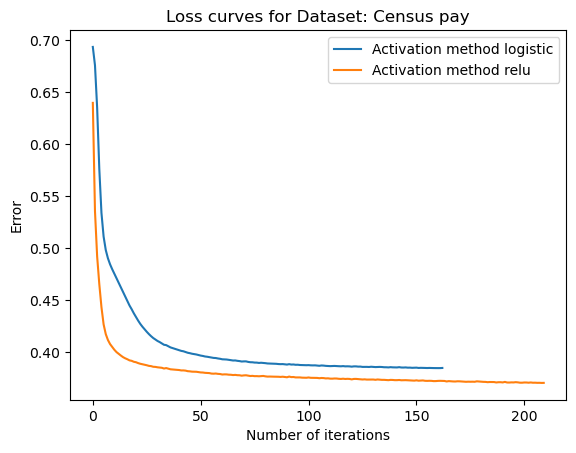

In [67]:
# --------------- looking for activation functions 

clf_1 = MLPClassifier(random_state=10, max_iter=500, solver='adam', learning_rate_init=0.001,
                      activation='logistic', hidden_layer_sizes =(10, 15))

clf_2 = MLPClassifier(random_state=10, max_iter=500, solver='adam', learning_rate_init=0.001,
                      activation='logistic', hidden_layer_sizes =(10, 10))

def start_training (clf, x_train1, y_train1, x_test11, y_test11, dname='Census pay', trti={}, tsti={}, 
                    acc={}, extra_clf = False ):
    
    start = time.time()
    clf.fit(x_train1, y_train1)
    end = time.time()
    trtime = end - start
    trti['nn'] = trtime
    
    if extra_clf == True:
        clf2=MLPClassifier(random_state=10, max_iter=500, solver='adam', learning_rate_init=0.001, 
        activation='relu', hidden_layer_sizes =(10, 15))
        clf2.fit(x_train1, y_train1)
        trs2 = clf2.score(x_train1, y_train1)
        ts2 = clf2.score(x_test11, y_test11)
        l2 = 'Activation method '+ str(clf2.activation)
        print("score with clf2", trs2, ts2)

    trs = clf.score(x_train1, y_train1)
    

    start = time.time()
    ts = clf.score(x_test11, y_test11)
    end = time.time()
    tstime = end - start
    tsti['nn'] = tstime
    acc['nn'] = ts
    

    print("Training score:", trs, " validation score:", ts)
    print("Training time", round(trtime, 4), " Testing time", round(tstime, 4), "seconds")

    l1 = 'Activation method '+ str(clf.activation)

    plt.plot(clf.loss_curve_, label=l1)
    if extra_clf == True:
        plt.plot(clf2.loss_curve_, label=l2)
    tit = "Loss curves for Dataset: " + dname 
    plt.ylabel("Error")
    plt.xlabel("Number of iterations")
    plt.title(tit)
    plt.legend()
    plt.show()
    
start_training(clf_1, x_train1, y_train1, x_test11, y_test11, 'Census pay', traintimesd1, testtimesd1, final_accsd1, True) 
# start_training(clf_2, x_train2, y_train2, x_test22, y_test22, "Body Performance", traintimesd2,testtimesd2, final_accsd2, False) 

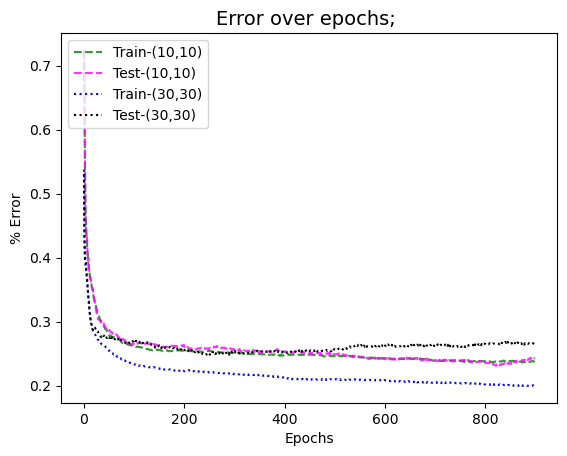

In [33]:
#------------- analyzing iterations and loss --------------

N_TRAIN_SAMPLES = x_train2.shape[0]
N_EPOCHS = 900
N_BATCH = x_train2.shape[0]
N_CLASSES = np.unique(y_train2)

scores_train1 = []
scores_test1 = []

scores_train2 = []
scores_test2 = []
       
    
mlp1 = MLPClassifier(random_state=10, max_iter=1, solver='adam', learning_rate_init=0.001,
                    activation='relu', hidden_layer_sizes =(10, 10), warm_start=True)
mlp2 = MLPClassifier(random_state=10, max_iter=1, solver='adam', learning_rate_init=0.001,
                    activation='relu', hidden_layer_sizes =(30, 30), warm_start=True)
# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    mlp1.partial_fit(x_train2, y_train2, N_CLASSES)
    scores_train1.append(1-mlp1.score(x_train2, y_train2))
    scores_test1.append(1-mlp1.score(x_val2, y_val2))
    
    mlp2.partial_fit(x_train2, y_train2, N_CLASSES)
    scores_train2.append(1-mlp2.score(x_train2, y_train2))
    scores_test2.append(1-mlp2.score(x_val2, y_val2))

    epoch += 1

""" Plot """
plt.plot(scores_train1, color='green', alpha=0.8, label='Train-(10,10)', linestyle= '--')
plt.plot(scores_test1, color='magenta', alpha=0.8, label='Test-(10,10)', linestyle ='--')
plt.plot(scores_train2, color='blue', alpha=1, label='Train-(30,30)', linestyle=':')
plt.plot(scores_test2, color='black', alpha=1, label='Test-(30,30)',linestyle=':')

plt.title("Error over epochs; ", fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('% Error')
plt.legend(loc='upper left')
plt.show()

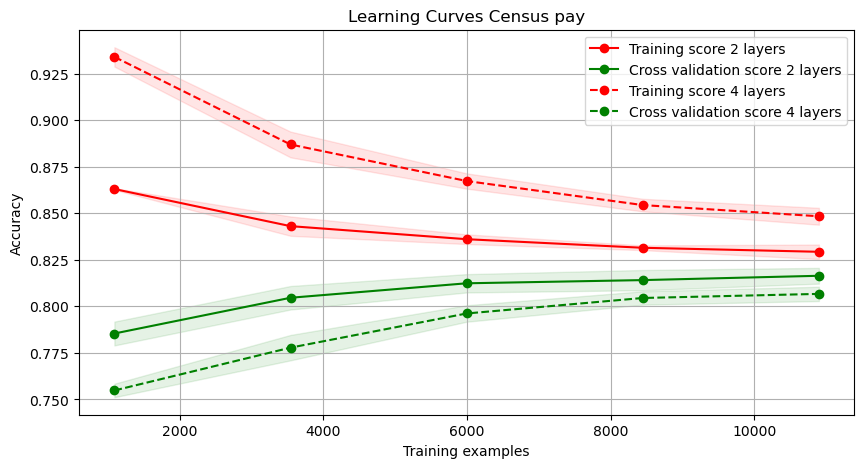

In [34]:
clf1=MLPClassifier(random_state=10, max_iter=500, solver='adam', learning_rate_init=0.01, 
    activation='relu', hidden_layer_sizes =(15, 15, 15, 15))
clf2=MLPClassifier(random_state=10, max_iter=500, solver='adam', learning_rate_init=0.001, 
    activation='relu', hidden_layer_sizes =(50, 50))
clf_2 = MLPClassifier(random_state=10, max_iter=500, solver='adam', learning_rate_init=0.1, 
    activation='relu', hidden_layer_sizes =(10, 10))


fig, axes = plt.subplots(1, 1, figsize=(10, 5))
title="Learning Curves"

plot_learning_curve_newdata(clf_1, title, X= x_train1, y=y_train1, axes=axes, ylim=None, cv=3,  n_jobs=-1,
                            scoring="accuracy",  train_sizes=np.linspace(0.1, 1.0, 5), d_name="Census pay",
                            estimator2=clf1, sp1='2 layers', sp2='4 layers', X2=x_train1,
                            y2=y_train1)




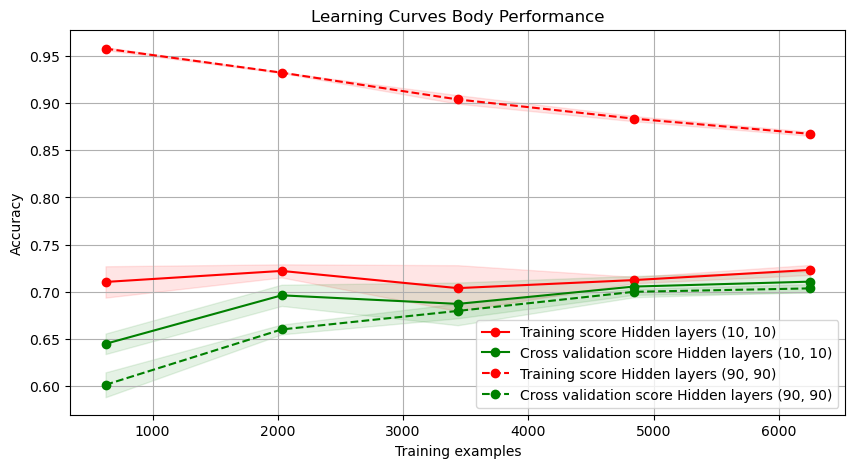

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
title="Learning Curves"

plot_learning_curve_newdata(clf_2, title, X= x_train2, y=y_train2, axes=axes, ylim=None, cv=3,  n_jobs=-1,
                            scoring="accuracy",  train_sizes=np.linspace(0.1, 1.0, 5), d_name="Body Performance",
                            estimator2=clf2, sp1='Hidden layers (10, 10)', sp2='Hidden layers (90, 90)', X2=x_train2,
                            y2=y_train2)

### Support Vector Machines
#### Linear kernel

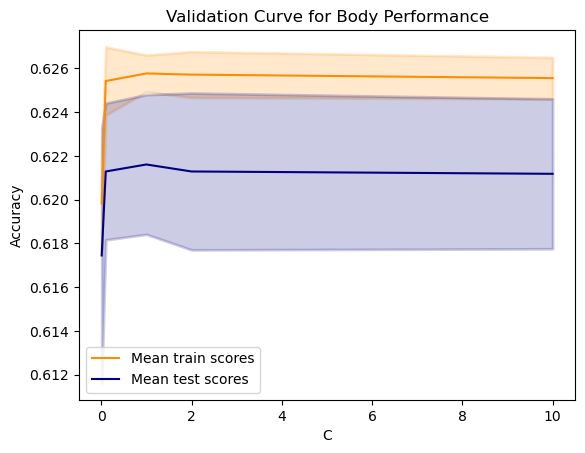

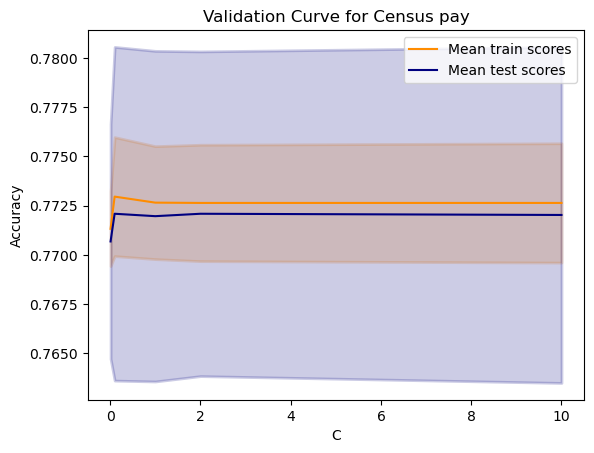

In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC


svl = SVC(kernel='linear')
c_range =[0.01, 0.1, 1, 2,  10]

val_curve(svl, x_train2, y_train2, "C", c_range, "accuracy", "Body Performance")
val_curve(svl, x_train1, y_train1, "C", c_range, "accuracy", "Census pay")


In [37]:
# x_train1, x_test1, x_train2, x_test2 
svl = SVC(kernel='linear', C=2)


def support_vector(clf, x_scaled1, y_train1, xtest_scaled1, y_test1, dname='Census pay'):
    start = time.time()
    clf.fit(x_scaled1, y_train1)
    end = time.time()
    trtime = end - start 
    
    trs = clf.score(x_scaled1, y_train1)
    s = time.time()
    ts = clf.score(xtest_scaled1, y_test1)
    e = time.time()
    tt = e - s

    print("----------------------------------------------------------")
    print("SVM for Dataset", dname)
    print("Training time", round(trtime, 4), " Testing time", round(tt, 4), "seconds")
    print("Training score", trs, " Testing score", ts)
    
    
support_vector(svl, x_scaled1, y_train1, xtest_scaled1, y_test1)
support_vector(svl, x_scaled2, y_train2, xtest_scaled2, y_test2, "Body Performance")

----------------------------------------------------------
SVM for Dataset Census pay
Training time 15.7064  Testing time 2.202 seconds
Training score 0.7728245581850425  Testing score 0.7594521329718933
----------------------------------------------------------
SVM for Dataset Body Performance
Training time 5.3937  Testing time 0.8503 seconds
Training score 0.6236398549178579  Testing score 0.6251866600298656


#### RBF kernel of the SVM

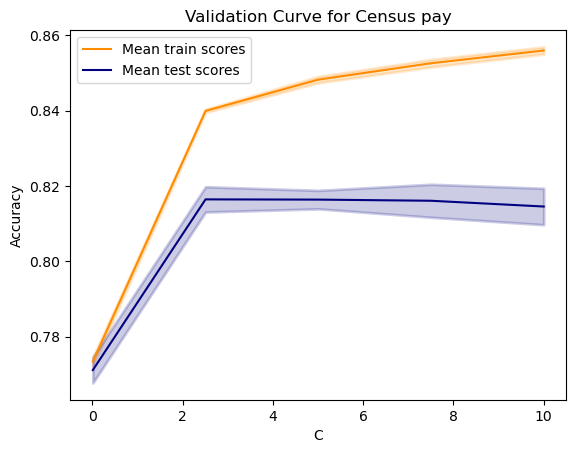

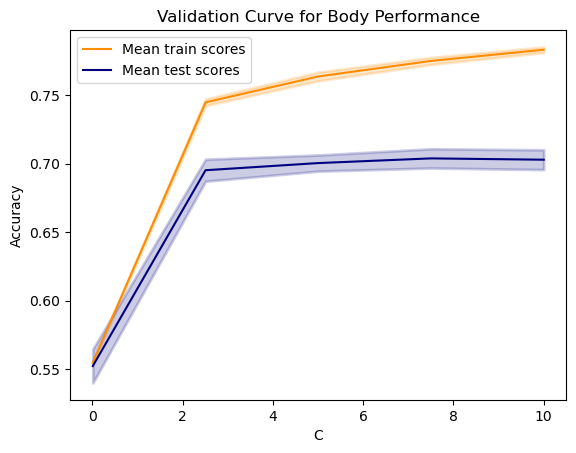

In [38]:

# x_train1, x_test1, x_train2, x_test2 

svr = SVC(kernel='rbf')
c_range = np.linspace(0.01, 10, 5)
g_range = [0.001, 0.006, 0.05, 0.1, 0.2]

val_curve(svr, x_train1, y_train1, "C", c_range, "accuracy", "Census pay")
val_curve(svr, x_train2, y_train2, "C", c_range, "accuracy", "Body Performance")


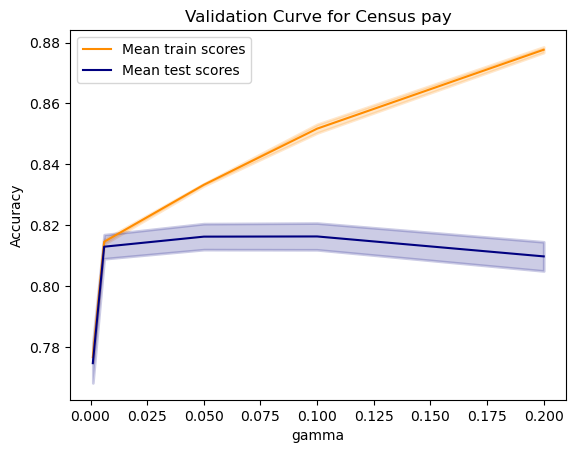

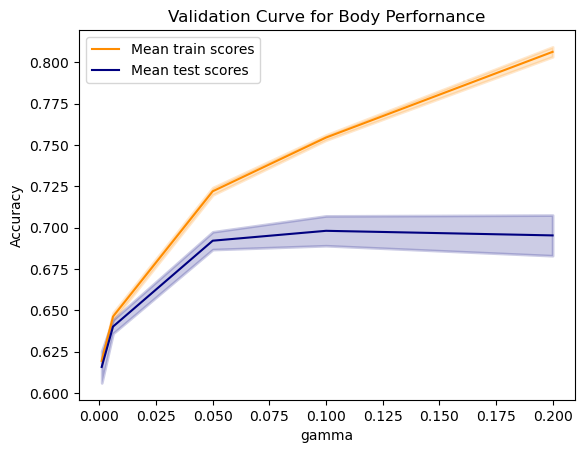

In [39]:
svr = SVC(kernel='rbf', C=3)

val_curve(svr, x_train1, y_train1, "gamma",g_range, "accuracy", "Census pay", False)
val_curve(svr, x_train2, y_train2, "gamma",g_range, "accuracy", "Body Perfornance", False)


In [40]:

svr1 = SVC(kernel='rbf', C=3, gamma=0.01)
svr2 = SVC(kernel='rbf', C=3, gamma=0.1)

def support_vector(clf, x_scaled1, y_train1, xtest_scaled1, y_test1, dname='Census pay', trt={}, tst={}, acc = {}):
    start = time.time()
    clf.fit(x_scaled1, y_train1)
    end = time.time()
    trtime = end - start 
    trt['svm']=trtime
    
    trs = clf.score(x_scaled1, y_train1)
    s = time.time()
    ts = clf.score(xtest_scaled1, y_test1)
    e = time.time()
    tt = e - s
    tst['svm'] = tt
    
    acc['svm'] = ts

    print("----------------------------------------------------------")
    print("SVM for Dataset", dname)
    print("Training time", round(trtime, 4), " Testing time", round(tt, 4), "seconds")
    print("Training score", trs, " Testing score", ts)

support_vector(svr1, x_scaled1, y_train1, xtest_scaled1, y_test1, "Census pay", traintimesd1, testtimesd1, final_accsd1)
print("-----------------------------------------------------------")
support_vector(svr2, x_scaled2, y_train2, xtest_scaled2, y_test2, "Body Performance", traintimesd2, testtimesd2, final_accsd2)


----------------------------------------------------------
SVM for Dataset Census pay
Training time 11.9453  Testing time 4.9538 seconds
Training score 0.8210725860698342  Testing score 0.8123840776144956
-----------------------------------------------------------
----------------------------------------------------------
SVM for Dataset Body Performance
Training time 4.3916  Testing time 1.8384 seconds
Training score 0.7535737145295498  Testing score 0.7125435540069687


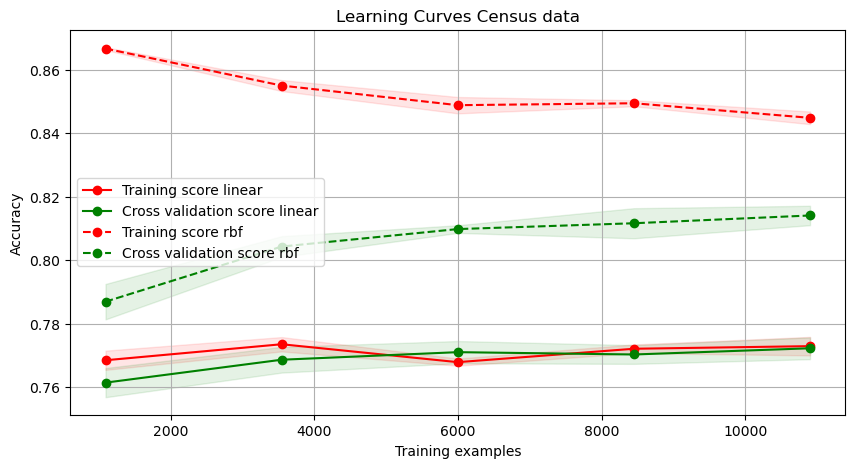

In [41]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
title="Learning Curves"

plot_learning_curve_newdata(svl, title, X= x_scaled1, y=y_train1, axes=axes, ylim=None, cv=3,  n_jobs=-1,
                            scoring="accuracy",  train_sizes=np.linspace(0.1, 1.0, 5), d_name="Census data",
                            estimator2=svr, sp1='linear', sp2='rbf', X2=x_scaled1,
                            y2=y_train1)



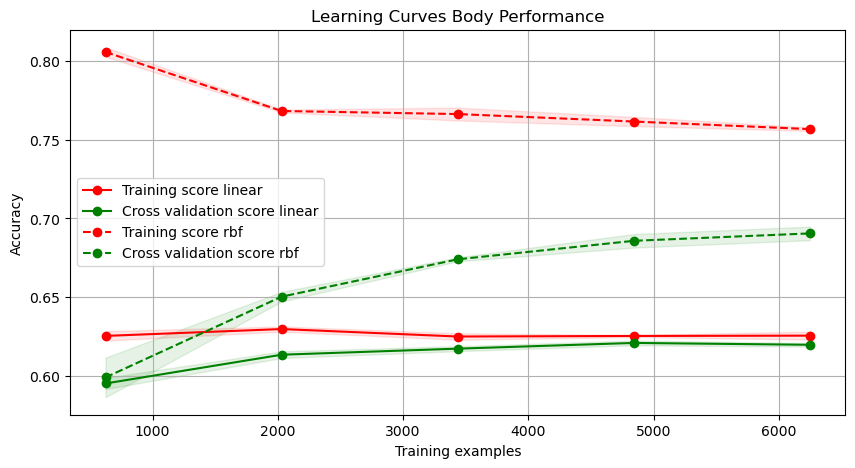

In [42]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
title="Learning Curves"
svr2 = SVC(kernel='rbf', C=3, gamma=0.1)

plot_learning_curve_newdata(svl, title, X= x_scaled2, y=y_train2, axes=axes, ylim=None, cv=3,  n_jobs=-1,
                            scoring="accuracy",  train_sizes=np.linspace(0.1, 1.0, 5), d_name="Body Performance",
                            estimator2=svr2, sp1='linear', sp2='rbf', X2=x_scaled2,  y2=y_train2)


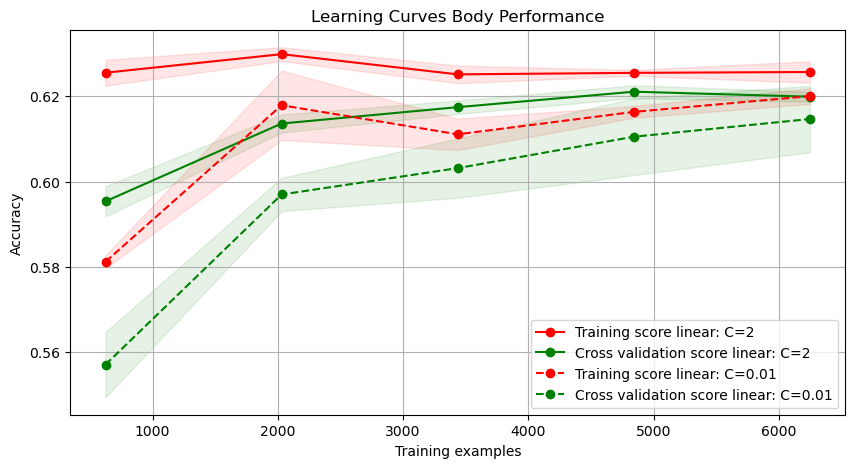

In [43]:

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
title="Learning Curves"

svl = SVC(kernel='linear', C=2)
svl2 = SVC(kernel='linear', C=0.01)

plot_learning_curve_newdata(svl, title, x_scaled2, y_train2, axes=axes, ylim=None, cv=3,  n_jobs=-1, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5), d_name="Body Performance", estimator2=svl2, sp1='linear: C=2', 
                     sp2='linear: C=0.01', X2=x_scaled2, y2=y_train2)

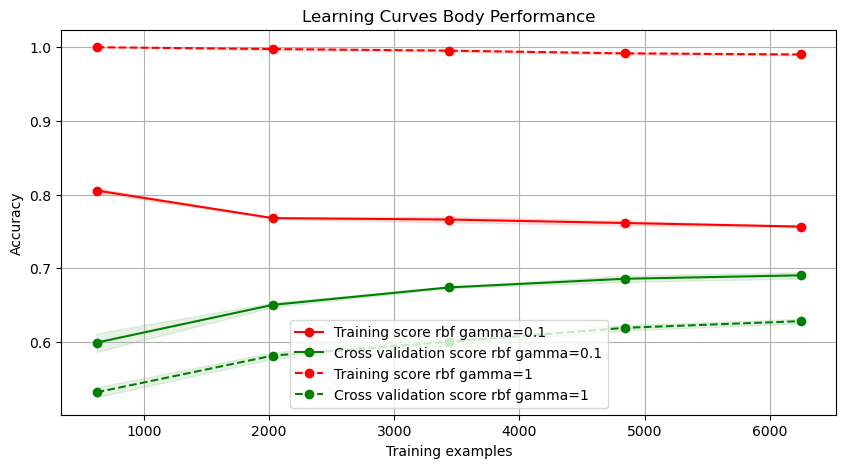

In [44]:

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
title="Learning Curves"

svr01 = SVC(kernel='rbf', C=3, gamma=0.1)
svr1 = SVC(kernel='rbf', C=3, gamma=1)

plot_learning_curve_newdata(svr01, title, x_scaled2, y_train2, axes=axes, ylim=None, cv=3,  n_jobs=-1, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5), d_name="Body Performance", estimator2=svr1, sp1='rbf gamma=0.1', 
                     sp2='rbf gamma=1', X2=x_scaled2, y2=y_train2)

### Adaboost

In [46]:

from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier()

def adaboost(clf, x_scaled1, y_train1, xtest_scaled1, y_test1, dname='Census pay'):
    start = time.time()
    clf.fit(x_scaled1, y_train1)
    end = time.time()
    trtime = end - start 

    trs = clf.score(x_scaled1, y_train1)
    s = time.time()
    ts = clf.score(xtest_scaled1, y_test1)
    e = time.time()
    tt = e - s

    print("----------------------------------------------------------")
    print("Adaboost for Dataset", dname)
    print("Training time", round(trtime, 4), " Testing time", round(tt, 4), "seconds")
    print("Training score", trs, " Testing score", ts)


adaboost(ab, X_train1, y_train1, X_test1, y_test1)
print("-----------------------------------------------------------")
adaboost(ab, X_train2, y_train2, X_test2, y_test2, "Body Performance")


----------------------------------------------------------
Adaboost for Dataset Census pay
Training time 0.5743  Testing time 0.0543 seconds
Training score 0.8261481073809087  Testing score 0.8233699529176772
-----------------------------------------------------------
----------------------------------------------------------
Adaboost for Dataset Body Performance
Training time 0.4339  Testing time 0.0475 seconds
Training score 0.608491572434393  Testing score 0.6012941762070682


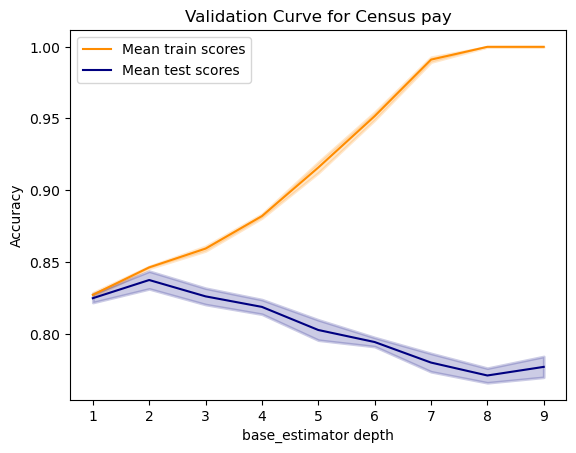

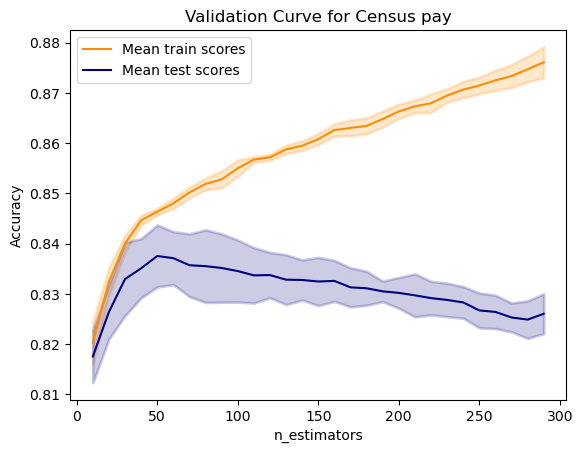

In [47]:
ab = AdaBoostClassifier()
max_depth_range = list(range(1, 10, 1))
dcs = [DecisionTreeClassifier(max_depth=k) for k in max_depth_range]
e_range=list(range(0, 300, 10))
val_curve2(ab, x_train1, y_train1, "base_estimator", dcs, "accuracy", "Census pay", max_depth_range)

ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2))
val_curve(ab, x_train1, y_train1, "n_estimators", e_range, "accuracy", "Census pay")


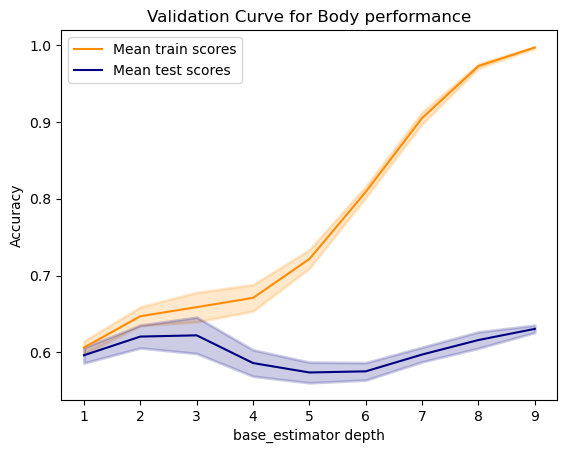

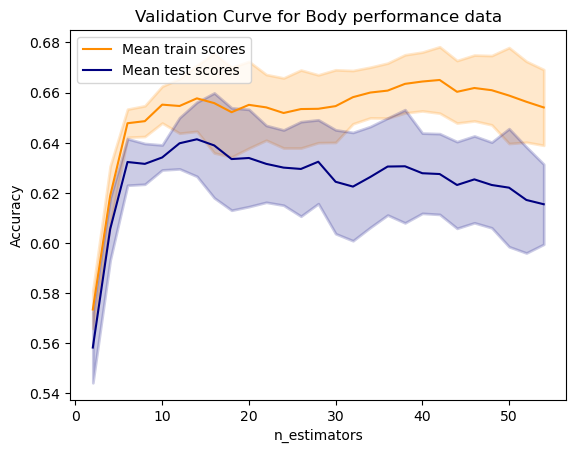

In [48]:
val_curve2(ab, X_train2, y_train2, "base_estimator", dcs, "accuracy", "Body performance", max_depth_range)
ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3))
e_range=list(range(0, 55, 2))
val_curve(ab, X_train2, y_train2, "n_estimators", e_range, "accuracy", "Body performance data")


In [92]:
ab1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators = 50)
ab2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators = 12)

def adaboost(clf, x_scaled1, y_train1, xtest_scaled1, y_test1, dname='Census pay', trt={}, tst ={}, acc={}):
    start = time.time()
    clf.fit(x_scaled1, y_train1)
    end = time.time()
    trtime = end - start 
    trt['ab'] = trtime

    trs = clf.score(x_scaled1, y_train1)
    s = time.time()
    ts = clf.score(xtest_scaled1, y_test1)
    e = time.time()
    tt = e - s
    tst['ab'] = tt
    acc['ab'] = ts
    print("----------------------------------------------------------")
    print("Adaboost for Dataset", dname)
    print("Training time", round(trtime, 4), " Testing time", round(tt, 4), "seconds")
    print("Training score", trs, " Testing score", ts)

adaboost(ab1, X_train1, y_train1, X_test1, y_test1, "Census pay", traintimesd1, testtimesd1, final_accsd1)
print("-----------------------------------------------------------")
adaboost(ab2, X_train2, y_train2, X_test2, y_test2, "Body Performance", traintimesd2, testtimesd2, final_accsd2)


----------------------------------------------------------
Adaboost for Dataset Census pay
Training time 0.94  Testing time 0.0596 seconds
Training score 0.8463890417660368  Testing score 0.8302182907690113
-----------------------------------------------------------
----------------------------------------------------------
Adaboost for Dataset Body Performance
Training time 0.2721  Testing time 0.0184 seconds
Training score 0.676125453381694  Testing score 0.6635141861622698


/home/ai/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/ai/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


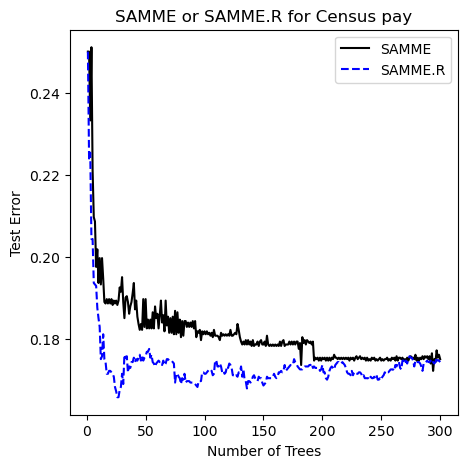

/home/ai/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/ai/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


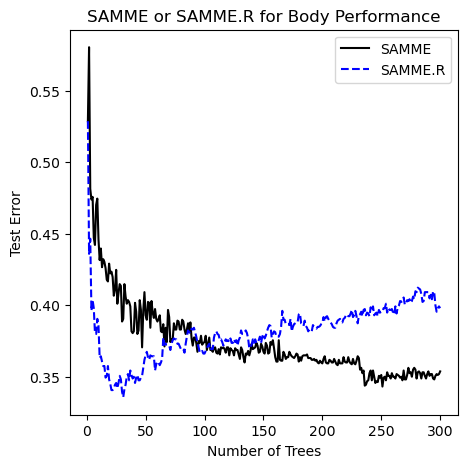

In [88]:
# Author: Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause

from sklearn.metrics import accuracy_score

def samme_or_sammer(X_train2, y_train2, X_test2, y_test2, dname):
    bdt_real = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=2), n_estimators=300, learning_rate=1
    )

    bdt_discrete = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=2),
        n_estimators=300,
        learning_rate=1,
        algorithm="SAMME",
    )

    bdt_real.fit(X_train2, y_train2)
    bdt_discrete.fit(X_train2, y_train2)

    real_test_errors = []
    discrete_test_errors = []

    for real_test_predict, discrete_train_predict in zip(
        bdt_real.staged_predict(X_test2), bdt_discrete.staged_predict(X_test2)
    ):
        real_test_errors.append(1.0 - accuracy_score(real_test_predict, y_test2))
        discrete_test_errors.append(1.0 - accuracy_score(discrete_train_predict, y_test2))

    n_trees_discrete = len(bdt_discrete)
    n_trees_real = len(bdt_real)

    # Boosting might terminate early, but the following arrays are always
    # n_estimators long. We crop them to the actual number of trees here:
    discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
    real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
    discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

    plt.figure(figsize=(5, 5))

    plt.plot(range(1, n_trees_discrete + 1), discrete_test_errors, c="black", label="SAMME")
    plt.plot(
        range(1, n_trees_real + 1),
        real_test_errors,
        c="blue",
        linestyle="dashed",
        label="SAMME.R",
    )
    plt.legend()
#     plt.ylim(0.18, 0.62)
    tit = "SAMME or SAMME.R for " + dname
    plt.title(tit)
    plt.ylabel("Test Error")
    plt.xlabel("Number of Trees")

    plt.show()
samme_or_sammer(x_train1, y_train1, x_val1, y_val1, "Census pay")
samme_or_sammer(x_train2, y_train2, x_val2, y_val2, "Body Performance")

In [78]:
X_train

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
3975,-0.660013,1.630728,-1.338641,1.277616,-0.235177,-1.802236,0.258362,-0.115528,0.360209,-1.653091,-0.198029,-0.255532,-0.580857,0.249834
1165,-0.430134,-0.086862,0.837020,-0.421497,0.912952,-0.314542,0.761638,-0.732320,-2.136823,0.604927,-0.198029,-0.255532,-0.336233,0.249834
3861,-1.809407,-0.086862,-0.434767,-2.970165,-1.766017,1.173152,0.258362,1.118056,-2.136823,-1.653091,-0.198029,-0.255532,-2.456309,0.249834
5259,-1.273023,-0.086862,0.002670,-0.421497,0.912952,-0.314542,1.264913,-0.732320,0.360209,0.604927,-0.198029,-0.255532,-0.173150,0.249834
4906,1.945280,2.489523,-1.478870,0.144874,-0.617887,-0.314542,-0.748189,-0.732320,0.360209,0.604927,-0.198029,-0.255532,0.234557,0.249834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4965,-1.579528,-0.086862,0.379879,1.277616,-0.235177,1.173152,0.258362,1.118056,0.360209,0.604927,-0.198029,-0.255532,0.642264,0.249834
4848,-1.119771,-0.086862,-0.824054,-2.970165,-1.766017,1.173152,-0.748189,1.734848,-4.633856,-1.653091,-0.198029,-0.255532,-0.173150,0.249834
3549,0.182876,-2.663246,0.415155,0.144874,-0.617887,-0.314542,-1.503102,2.351640,0.360209,-1.653091,-0.198029,-0.255532,-0.173150,0.249834
1242,0.336128,-0.086862,-0.033861,0.144874,-0.617887,-0.314542,-0.244913,-0.732320,-2.136823,0.604927,0.477242,-0.255532,-0.173150,0.249834


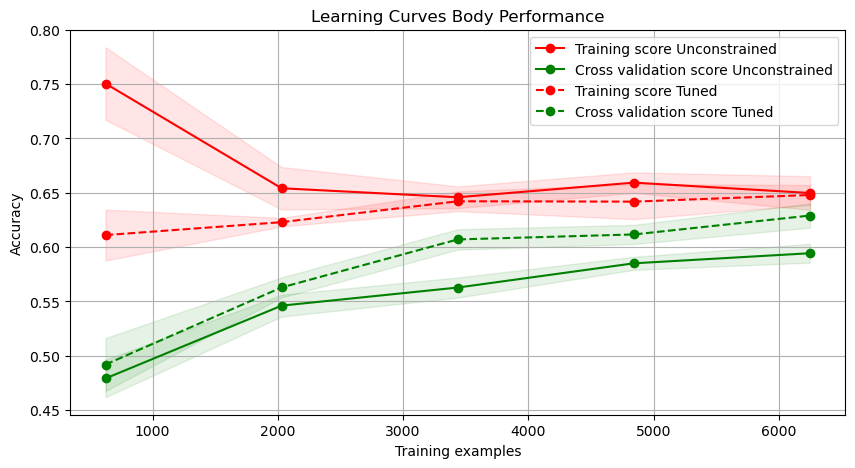

In [50]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
title="Learning Curves"

ab2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators = 12)

plot_learning_curve_newdata(ab, title, x_scaled2, y_train2, axes=axes, ylim=None, cv=3,  n_jobs=-1, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5), d_name="Body Performance", estimator2=ab2, sp1='Unconstrained', 
                     sp2='Tuned', X2=x_scaled2, y2=y_train2)

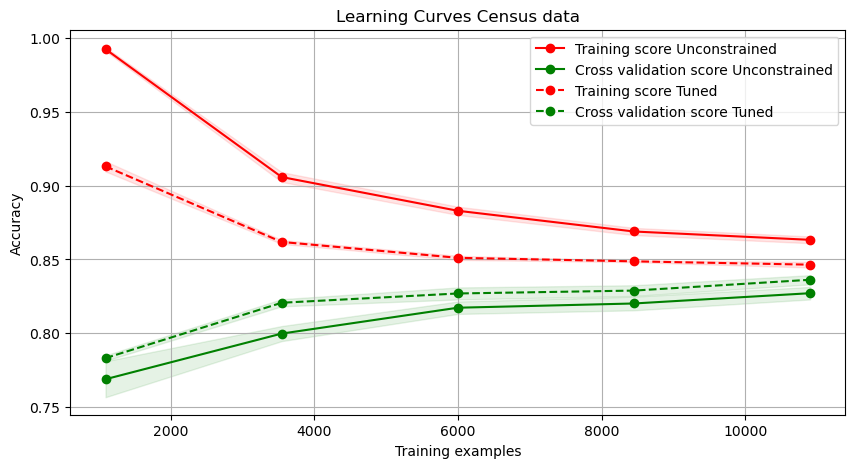

In [51]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
title="Learning Curves"

plot_learning_curve_newdata(ab, title, x_scaled1, y_train1, axes=axes, ylim=None, cv=3,  n_jobs=-1, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5), d_name="Census data", estimator2=ab1, sp1='Unconstrained', 
                     sp2='Tuned', X2=x_scaled1, y2=y_train1)

<Figure size 1000x500 with 0 Axes>

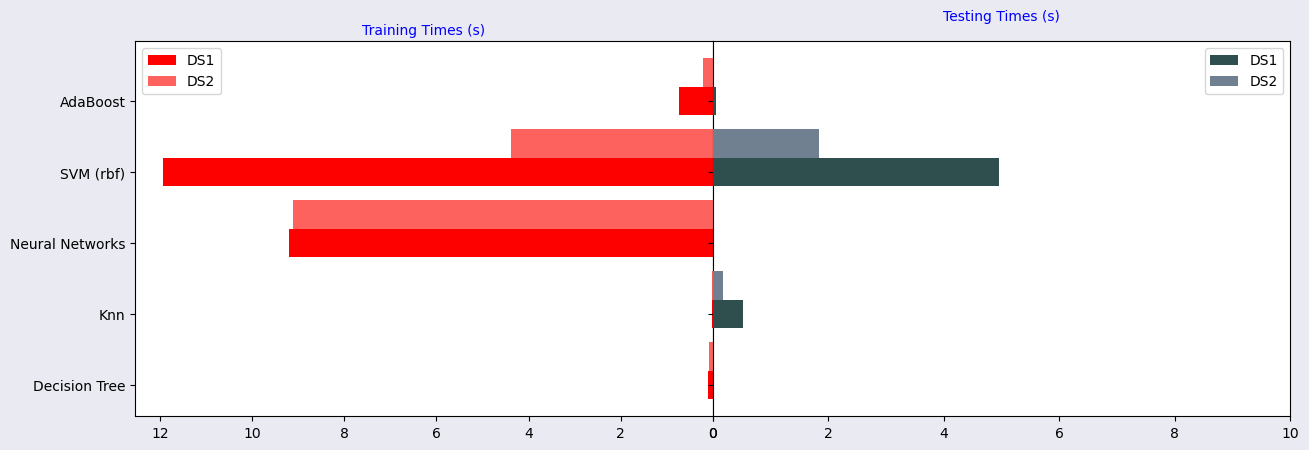

In [57]:
plt.figure(figsize=(10, 5))

labels = ['Decision Tree', 'Knn', 'Neural Networks', 'SVM (rbf)', 'AdaBoost']
X = np.arange(0, len(traintimesd1))
font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_red2 = '#fd0000'

title0 = 'Training Times (s)'
title1 = 'Testing Times (s)'

fig, axes = plt.subplots(figsize=(15,5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(X, traintimesd1.values(), align='center', color=color_red2, zorder=10, height=0.4, label = 'DS1')
axes[0].barh(X+0.4, traintimesd2.values(), align='center', color=color_red, zorder=10,  height=0.4, label='DS2')
axes[0].set_title(title0, fontsize=10, pad=5, color='b', **hfont)


axes[1].barh(X, testtimesd1.values(), align='center', color='darkslategray', zorder=10, height=0.4, label='DS1')
axes[1].barh(X+0.4, testtimesd2.values(), align='center', color='slategray', zorder=10, height=0.4, label='DS2')
axes[1].set_title(title1, fontsize=10, pad=15, color='b', **hfont)


plt.yticks(X, labels)
plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
axes[0].legend()
axes[1].legend()

axes[1].set_xlim(0, 10)
axes[0].invert_xaxis() 

plt.show()







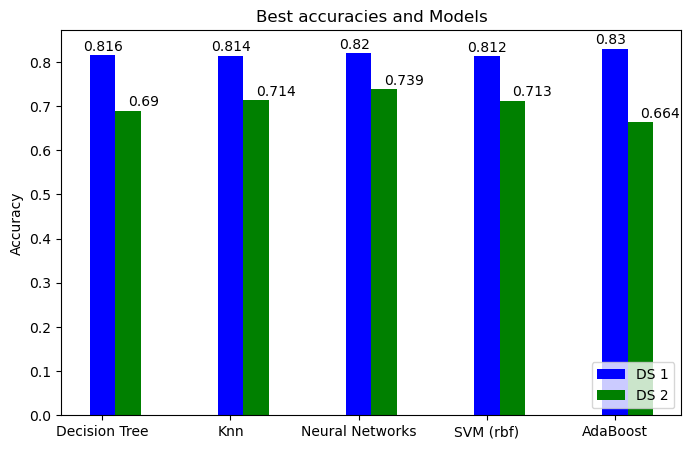

In [58]:
fig, ax = plt.subplots(figsize=(8,5))
ax = plt.gca()
X = np.arange(0, len(final_accsd1))

ax.bar(X, final_accsd1.values(), color = 'b', width = 0.2, label = 'DS 1')
ax.bar(X+0.20,final_accsd2.values(), color = 'g', width = 0.2, label = "DS 2")
plt.xticks(X, labels)
plt.title('Best accuracies and Models')
for i, v in enumerate(final_accsd1.values()):
    plt.text(X[i] - 0.15, v + 0.01, str(round(v,3)))
for i, v in enumerate(final_accsd2.values()):
    plt.text(X[i]+0.2 , v + 0.01, str(round(v,3)))
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

    